# TABLE OF CONTENTS (and quick preview of its results)
**INTRODUCTION**

**BASIC PREPARATION**
- connect to drive (for colab), check if GPU available etc.
- Prepare new dataset to train splitted 75%/10%/15%
- Process images to work with network (without data augumentation for now)

**TRAIN FEW VERSIONS OF MODEL BASING ON XCEPTION**
- Test xception with replaced output layer but no traing **[test acc 22%]**
- Train more combinations (5 epochs with/without freezing base model, then 10 epochs with unfreezed)

**SUMMARISE PART**
- Analize metrics on last epoch **[best accuracy on test was 93.09%]**
- Analize accuracy/loss during each epoch for each model
	- Train was still improving with no change on validatoin that suggests overfitting **[reguralization may help]**
	- most has big difference between train/validation which suggests that **[model may lack samples to generalize patterns]**

**ADD REGURALIZATION TO IMPROVE MODEL:**
- Add dropout in between without replacing dense layer **[training was not progressing further and stays on 92.54% acc]**
- Add dropout and replace tuned dense layer with new (reset weights) **[progressing from scratch, after 10 epochs also getting 92.54% acc]**
- Continue training as loss was still improving **[This was still progressing, we get best for now 93,27% and loss was still improving]**
- Try DROPOUT and L2 REGURALIZATION **[New best one - 93,45%]**
- Try DROPOUT and L2 REGURALIZATION without locking layers **[92,54% - wrong direction]**

**MAKE CHANGES TO ARCHITECTURE **
- skip last 13 layers (Assuming network is to complex to generalize) **[New best - 93,81%]**
- skip last 63 layers (Assuming network is to complex to generalize) **[after 40 epochs only 83,09% but still improving relatively fast]**
- skip last 63 layers, try bigger LR (assuming model have not enough time to adapt) **[We are getting close - 91,81%]**

**TRY DIFFERENT ARCHITECTURE (if even cutting-out of half xception is still too complex)**
- inspired by beggining of of xception **[63,9% - looks like this is finally too simple]**
- some basic conv2d layers connected **[70.36% and no progressing]**

**TEST DIFFERENT EXISTING NETWORK ARCHITECTURE - AlexNet**
- test architecture from pytorch (layer sizes mismatch sizes from papers) **[74,36% and visible overfitting]**
- test architecture with correct layersizes and additional batchnormalization (generated by LLM after asking for it) **[72,18%]**

**EXPERIMENT WITH ALEXNET AS BASE TRYING TO IMPROVE GENERALIZATION**
- add bunch of dense layers to see what happen **[56,00% - we are getting much worse]**
- Add more Conv2D layers instead of dense with freezing base **[75,09% - a little improvement but difference between train and validation is just getting bigger]**
- Unfreeze and continue **[77,09% without progressing anymore]**

**FINAL XCEPTION TEST**
- Try XCEPTION architecture without picking pre-trained weights to compare its accuracy **[81,81%]**
- Test if XCEPTION with data augumentation may break 95% accuracy **[96,36% - just as expected, best of all tests]**


# INTRODUCTION

The main goal is to pick some image data and test how well some network may reckognize it.
In my commercial job I have not practical application for this kind of networks and wanted to experiment with them a little.

Main goal:
- test how well perform network basing on pre-trained layers with known architecture vs creating something from scratch
- trying to analyze trainings and optymize network to improve results
- experiment a little with CNN layers and comparing different architectures implemented in papers

Assumptions:
- I don't wana spent much time on searching for good dataset - if picking just random will generates 100% corret answers i will try something harder, but if there will be room for improvements - i will stick to it
- I am assuming that picking networks trained on milions images and fine-tune them to small dataset shouldn't impact results much even if some smaple may overlap (I am picking different ouptuts so it need to re-learn final classes anwyway)
- I am expecting that data agumentation will be one of best thing to improve results and ignore this fact until very end of project to experiment with different approaches than "more data"
- I am expecting to relatively-easly allow network to find objects from another dataset with this method by using abilities to found features learnt during xception network was trained

I want to compare:
-    **xception_untrained** - Xception network without any training on the new dataset [baseline, probably the worst one]
-    **xception_short_train_unfrozen** - Xception trained for 5 epochs with all layers unfrozen  [it may either - break the existing knowledge or addept better]
-    **xception_short_train_frozen** - Xception trained for 5 epochs with base model layers frozen [i am assuming it may destroy existing knowledge but should be not limited as much]
-    **xception_fine_tuned_from_unfrozen** - Xception fine-tuned with additional epochs, starting from the short-trained model with unfrozen layers and then train with all unfrozen [may be good or bad, depends on previous results]
-    **xception_fine_tuned_from_frozen** - Xception fine-tuned with additional epochs, starting from the short-trained model with frozen layers and then train with all unfrozen [my default workflow in mind]

Then i just went with the flow and test a little more


# BASIC PREPARATION

## GPU and colab config

### Prepare connection with GPU

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn't guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [ ]:
# import os, pprint
# env_var = os.environ # Get the list of user's environment variables
# print("User's Environment variable:")
# pprint.pprint(dict(env_var), width = 1) # Print the list of user's environment variables

### Conenct to GDRIVE

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/xception_network
# !pwd

## Prepare summary object

In [3]:
summary = {
    'xception_untrained':{},
    'xception_short_train_unfrozen':{},
    'xception_short_train_frozen':{},
    'xception_fine_tuned_from_unfrozen':{},
    'xception_fine_tuned_from_frozen':{},
}

comments = {
    'xception_untrained':"",
    'xception_short_train_unfrozen':"",
    'xception_short_train_frozen':"",
    'xception_fine_tuned_from_unfrozen':"",
    'xception_fine_tuned_from_frozen':"",
}


In [4]:
comments = {
    'xception_untrained':"",
    'xception_short_train_unfrozen':"",
    'xception_short_train_frozen':"",
    'xception_fine_tuned_from_unfrozen':"",
    'xception_fine_tuned_from_frozen':"",
}

## Get new dataset to train

In [5]:
import tensorflow_datasets as tfds

In [36]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [11]:
dataset_size

3670

### Prepare train, cv, test sets

In [11]:
# --------------------------------------------------------------
# Previously used version on Splitting datase. Seems to dont work in my current tfds version
# --------------------------------------------------------------
# test_split, cv_split, train_set_raw_raw = tfds.Split.TRAIN.subsplit([10, 15, 75])

# test_set_raw= tfds.load("tf_flowers", split=test_split, as_supervised=True)
# valid_set_raw= tfds.load("tf_flowers", split=cv_split, as_supervised=True)
# train_set_raw = tfds.load("tf_flowers", split=train_set_raw_raw, as_supervised=True)

In [12]:
train_split = 'train[:75%]'
cv_split = 'train[75%:85%]'
test_split = 'train[85%:]'

train_set_raw = tfds.load('tf_flowers', split=train_split, as_supervised=True)
valid_set_raw = tfds.load('tf_flowers', split=cv_split, as_supervised=True)
test_set_raw= tfds.load('tf_flowers', split=test_split, as_supervised=True)

### As i am testing another method of splitting - i prefer to make sure that sets are not overlaping

In [13]:
# If any sample is overlaping we should ahve bigger sum than number of samples in trainset
print("Train, CV and test set lengths:")
print(train_set_raw.cardinality().numpy(), valid_set_raw.cardinality().numpy(), test_set_raw.cardinality().numpy())
size_of_splitted_dataset = (train_set_raw.cardinality().numpy() + valid_set_raw.cardinality().numpy() + test_set_raw.cardinality().numpy())
print(f"Sum of these: {size_of_splitted_dataset} which should be equal to orginal dataset size: {dataset_size}")
if size_of_splitted_dataset==dataset_size: print("All good")


Train, CV and test set lengths:
2752 368 550
Sum of these: 3670 which should be equal to orginal dataset size: 3670
All good


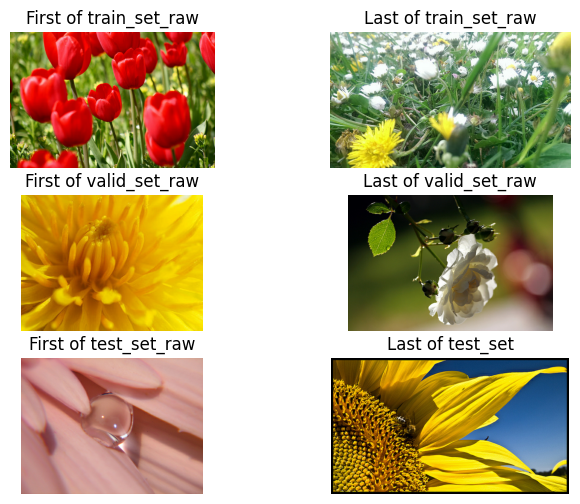

In [14]:
# --------------------------------------------------------------
# Additional check of first/last element of each set (to see if they are not duplicated between them)
# # --------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
index = 0
for image, label in train_set_raw.take(1):
    index += 1
    plt.subplot(3, 2, index)
    plt.imshow(image)
    plt.title("First of train_set_raw")
    plt.axis("off")

for image, label in train_set_raw.skip(train_set_raw.cardinality() - 1).take(1):
    index += 1
    plt.subplot(3, 2, index)
    plt.imshow(image)
    plt.title("Last of train_set_raw")
    plt.axis("off")

for image, label in valid_set_raw.take(1):
    index += 1
    plt.subplot(3, 2, index)
    plt.imshow(image)
    plt.title("First of valid_set_raw")
    plt.axis("off")

for image, label in valid_set_raw.skip(valid_set_raw.cardinality() - 1).take(1):
    index += 1
    plt.subplot(3, 2, index)
    plt.imshow(image)
    plt.title("Last of valid_set_raw")
    plt.axis("off")

for image, label in test_set_raw.take(1):
    index += 1
    plt.subplot(3, 2, index)
    plt.imshow(image)
    plt.title("First of test_set_raw")
    plt.axis("off")

for image, label in test_set_raw.skip(test_set_raw.cardinality() - 1).take(1):
    index += 1
    plt.subplot(3, 2, index)
    plt.imshow(image)
    plt.title("Last of test_set")
    plt.axis("off")
plt.show()


## Preprocsessing image to work with our network

xception network works with 224x224 images so we need to convert our dataset to that size

In [15]:
for image, label in train_set_raw.take(1):
    print("Orginal dataset image shape:", image.shape)
    break

Orginal dataset image shape: (333, 500, 3)


### Basic preprocessing

In [16]:
import tensorflow as tf
from tensorflow import keras
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [17]:
# Datasets backup after preprocessing
tf.data.Dataset.save(train_set, 'data/train_set')
tf.data.Dataset.save(valid_set, 'data/valid_set')
tf.data.Dataset.save(test_set, 'data/test_set')

### Alternative processing with data augumentation (maybe we tast it later)

In [18]:
# import tensorflow as tf
# from tensorflow import keras
# from functools import partial
# def central_crop(image):
#     shape = tf.shape(image)
#     min_dim = tf.reduce_min([shape[0], shape[1]])
#     top_crop = (shape[0] - min_dim) // 4
#     bottom_crop = shape[0] - top_crop
#     left_crop = (shape[1] - min_dim) // 4
#     right_crop = shape[1] - left_crop
#     return image[top_crop:bottom_crop, left_crop:right_crop]

# def random_crop(image):
#     shape = tf.shape(image)
#     min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
#     return tf.image.random_crop(image, [min_dim, min_dim, 3])

# def preprocess(image, label, randomize=False):
#     if randomize:
#         cropped_image = random_crop(image)
#         cropped_image = tf.image.random_flip_left_right(cropped_image)
#     else:
#         cropped_image = central_crop(image)
#     resized_image = tf.image.resize(cropped_image, [224, 224])
#     final_image = keras.applications.xception.preprocess_input(resized_image)
#     return final_image, label

# batch_size = 32
# train_set = train_set_raw.shuffle(1000)
# train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
# valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
# test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

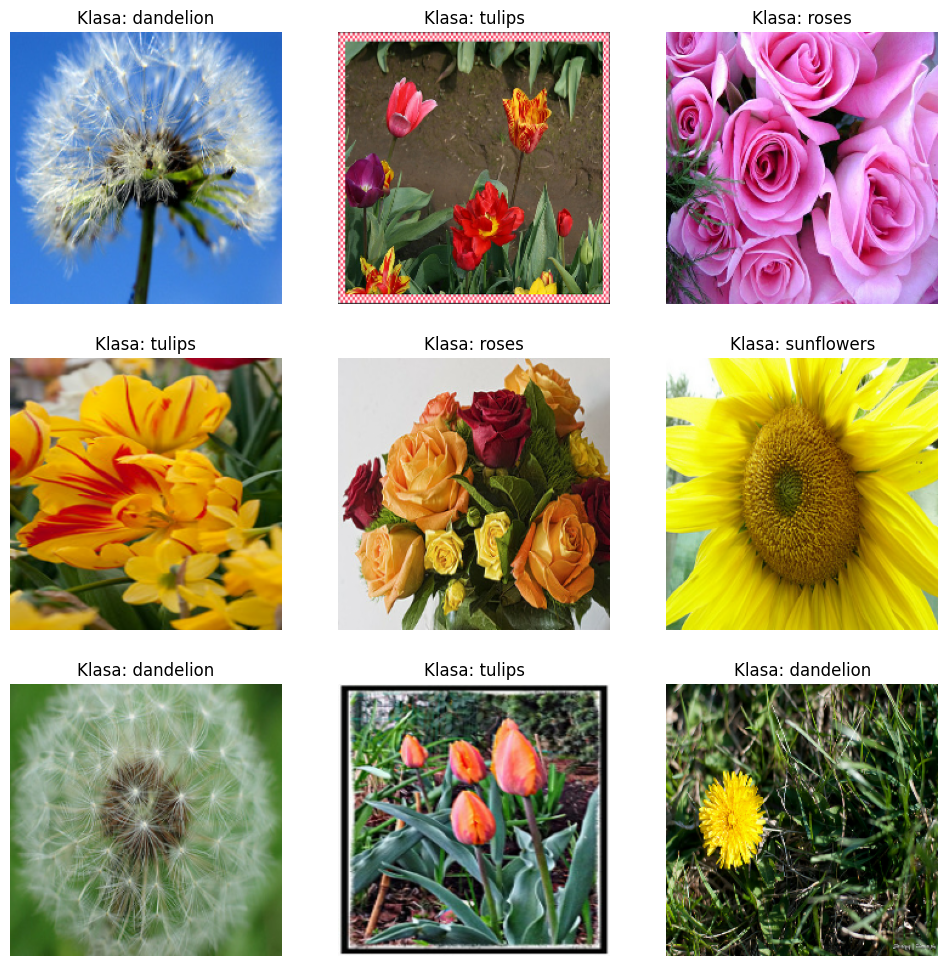

In [19]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Klasa: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [20]:
for image, label in train_set.take(1):
    print("Processed image shape:", image.shape)
    break

Processed image shape: (32, 224, 224, 3)


# TRAIN FEW VERSIONS OF MODEL BASING ON XCEPTION

## Create and test xception_untrained from existing Xception

In [21]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False) # Include top is skipping 2 top layers - AVG and softmax
avg = keras.layers.GlobalAveragePooling2D()(base_model.output) #We want to add them manually so we can train them
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

model_name = "xception_untrained"
model.save(f'models/{model_name}.keras')

### Check base structure

In [22]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

### Test model without training (New layers have randomly initialized weights, we are not changing them for now)

In [23]:
# from keras.models import load_model
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.2, momentum=0.9, decay=0.01) # We start with big LR to let NN faster get grasp of new data
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

summary[model_name] = {
    'accuracy':{
        'train':None,
        'val':None,
        'test':accuracy
    },
    'loss':{
        'train':None,
        'val':None,
        'test':loss
    },
    'epochs_of_training':0,
    'training_duration':0
}

c:\PythonScripts\image_classification\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


18/18 [==============================] - 8s 71ms/step - loss: 1.6380 - accuracy: 0.2200
Test loss: 1.6379731893539429
Test accuracy: 0.2199999988079071


## Create, train and test xception_short_train_unfrozen

In [24]:
from datetime import datetime

In [25]:
model_name = "xception_short_train_unfrozen"
epochs = 5
training_start = datetime.now()
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/5
86/86 [==============================] - 34s 329ms/step - loss: 0.9126 - accuracy: 0.6791 - val_loss: 1101.0106 - val_accuracy: 0.2772
Epoch 2/5
86/86 [==============================] - 28s 324ms/step - loss: 0.5636 - accuracy: 0.7980 - val_loss: 0.9186 - val_accuracy: 0.7609
Epoch 3/5
86/86 [==============================] - 27s 313ms/step - loss: 0.3048 - accuracy: 0.8884 - val_loss: 0.5552 - val_accuracy: 0.8641
Epoch 4/5
86/86 [==============================] - 27s 313ms/step - loss: 0.1542 - accuracy: 0.9459 - val_loss: 0.4233 - val_accuracy: 0.8804
Epoch 5/5
86/86 [==============================] - 27s 315ms/step - loss: 0.0870 - accuracy: 0.9727 - val_loss: 0.3532 - val_accuracy: 0.8995


In [26]:
model.save(f'models/{model_name}.keras')

import pickle
with open(f'history/{model_name}_history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [27]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

summary[model_name] = {
    'accuracy':{
        'train':history.history['accuracy'][-1],
        'val':history.history['val_accuracy'][-1],
        'test':accuracy
    },
    'loss':{
        'train':history.history['loss'][-1],
        'val':history.history['val_loss'][-1],
        'test':loss
    },
    'epochs_of_training':epochs,
    'training_duration':(training_end - training_start).total_seconds()
}

18/18 [==============================] - 1s 67ms/step - loss: 0.3107 - accuracy: 0.9055
Test loss: 0.3107061982154846
Test accuracy: 0.9054545164108276


### Prepare function to plot history of the training

In [24]:
def plot_training_history(history, figsize=(14,5), name_labels=True):
    try:
      history_dict = history.history
    except:
      history_dict = history # Quick fix to generate plots basing on picked history

    # Plot model accuracy and loss
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs_range = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Plot accuracy
    ax1.plot(epochs_range, acc, marker='s', label='Training Accuracy')
    ax1.plot(epochs_range, val_acc, marker='s', label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    if name_labels: ax1.set_xlabel('Epochs')
    if name_labels: ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    # Plot loss
    ax2.plot(epochs_range, loss, marker='s', label='Training Loss')
    ax2.plot(epochs_range, val_loss, marker='s', label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    if name_labels: ax2.set_xlabel('Epochs')
    if name_labels: ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# prompt: Try to create plot_training_history_with_comment funciton which will be working just like plot_training_history but with another variable (comment) that will be displayed on 3rd subplot area (next to previous 2) and contains only text in comment varibale
def plot_training_history_with_comment(history, comment, figsize=(14,5), name_labels=True):
    try:
      history_dict = history.history
    except:
      history_dict = history # Quick fix to generate plots basing on picked history

    # Plot model accuracy and loss
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs_range = range(1, len(acc) + 1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)

    # Plot accuracy
    ax1.plot(epochs_range, acc, marker='s', label='Training Accuracy')
    ax1.plot(epochs_range, val_acc, marker='s', label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    if name_labels: ax1.set_xlabel('Epochs')
    if name_labels: ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    # Plot loss
    ax2.plot(epochs_range, loss, marker='s', label='Training Loss')
    ax2.plot(epochs_range, val_loss, marker='s', label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    if name_labels: ax2.set_xlabel('Epochs')
    if name_labels: ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')

    # Plot comment
    ax3.axis('off')  # Turn off the axis
    ax3.text(0.01, 0.99, comment, ha='left', va='top', wrap=True)

    plt.tight_layout()
    plt.show()


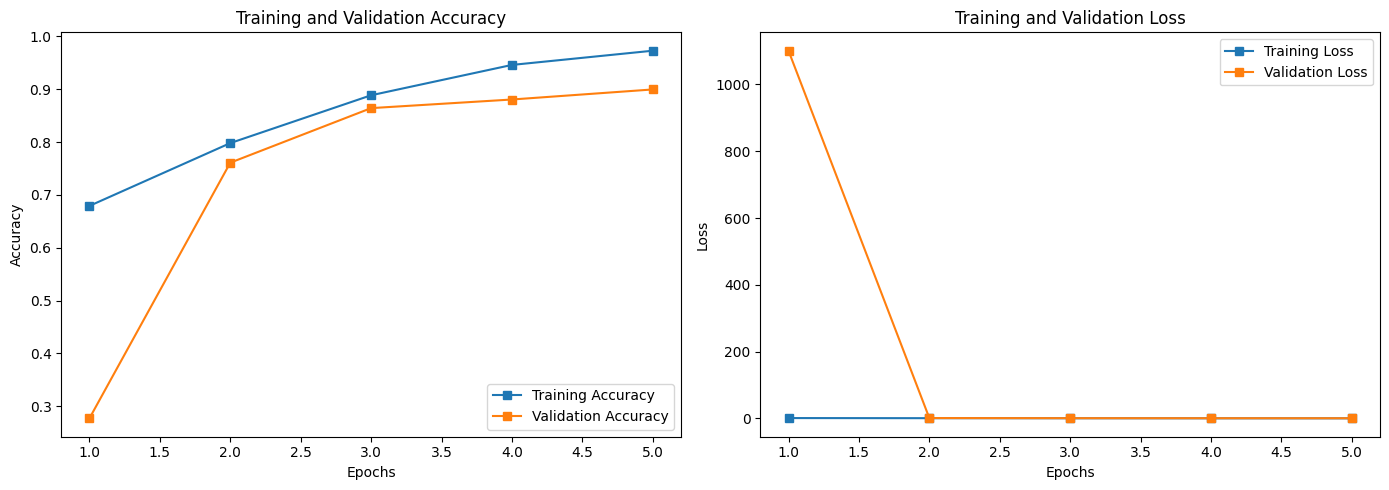

In [29]:
plot_training_history(history)

### Comment:

In [30]:
comment_model_name = "xception_short_train_unfrozen" # We re-define model name in this cell in case we want to update comment later
comments[comment_model_name] = \
f"""######## {comment_model_name}
• Both, train and validation error was still gettting smaller
• It means we still should continue training as it is not overfitted yet and it is still getting better
"""
print(comments[comment_model_name])

######## xception_short_train_unfrozen
• Both, train and validation error was still gettting smaller
• It means we still should continue training as it is not overfitted yet and it is still getting better



## Create, train and test xception_fine_tuned_from_unfrozen

In [31]:
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.01, momentum=0.9, decay=0.001) #We are changing learning rate to smaller value assuming that model is know more or less how our data looks like
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [32]:
model_name = "xception_fine_tuned_from_unfrozen"
epochs = 10
training_start = datetime.now()
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/10
86/86 [==============================] - 30s 310ms/step - loss: 0.0444 - accuracy: 0.9866 - val_loss: 0.2503 - val_accuracy: 0.9185
Epoch 2/10
86/86 [==============================] - 26s 302ms/step - loss: 0.0327 - accuracy: 0.9920 - val_loss: 0.2262 - val_accuracy: 0.9348
Epoch 3/10
86/86 [==============================] - 27s 309ms/step - loss: 0.0194 - accuracy: 0.9953 - val_loss: 0.2282 - val_accuracy: 0.9293
Epoch 4/10
86/86 [==============================] - 27s 313ms/step - loss: 0.0189 - accuracy: 0.9938 - val_loss: 0.2586 - val_accuracy: 0.9321
Epoch 5/10
86/86 [==============================] - 27s 312ms/step - loss: 0.0225 - accuracy: 0.9945 - val_loss: 0.2290 - val_accuracy: 0.9266
Epoch 6/10
86/86 [==============================] - 27s 312ms/step - loss: 0.0088 - accuracy: 0.9971 - val_loss: 0.2390 - val_accuracy: 0.9239
Epoch 7/10
86/86 [==============================] - 27s 311ms/step - loss: 0.0110 - accuracy: 0.9964 - val_loss: 0.2377 - val_accuracy: 0.9293

In [33]:
model.save(f'models/{model_name}.keras')

import pickle
with open(f'history/{model_name}_history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [34]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

summary[model_name] = {
    'accuracy':{
        'train':history.history['accuracy'][-1],
        'val':history.history['val_accuracy'][-1],
        'test':accuracy
    },
    'loss':{
        'train':history.history['loss'][-1],
        'val':history.history['val_loss'][-1],
        'test':loss
    },
    'epochs_of_training':epochs,
    'training_duration':(training_end - training_start).total_seconds()
}

18/18 [==============================] - 1s 69ms/step - loss: 0.2623 - accuracy: 0.9273
Test loss: 0.2623023986816406
Test accuracy: 0.9272727370262146


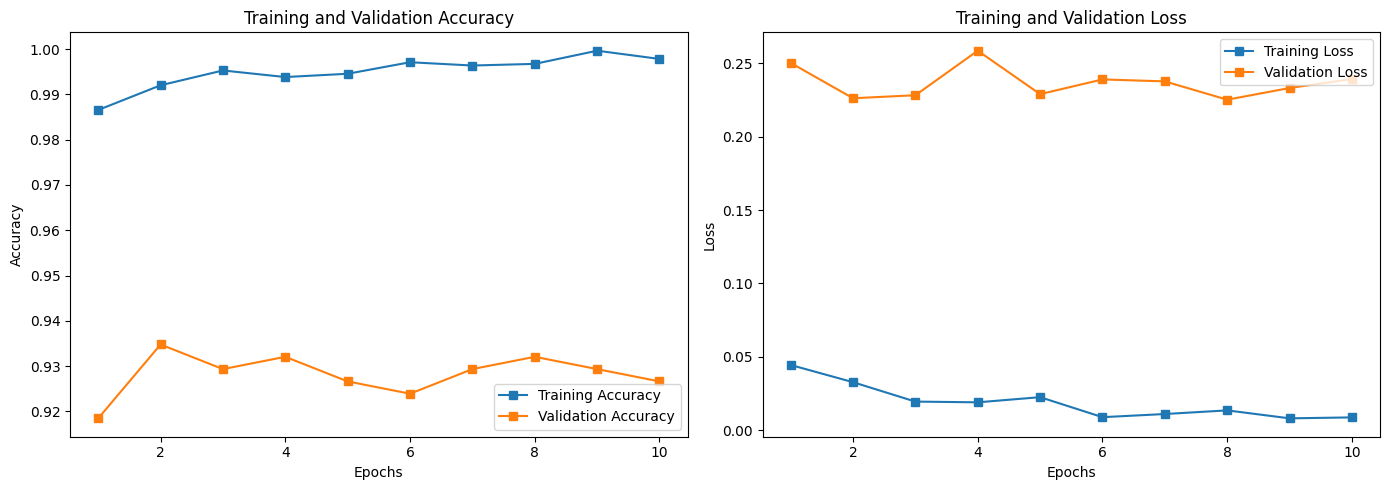

In [35]:
plot_training_history(history)

### Comment:

In [36]:
comment_model_name = "xception_fine_tuned_from_unfrozen" # We re-define model name in this cell in case we want to update comment later
comments[comment_model_name] = \
f"""######## {comment_model_name}
• training have no clear direction
• it switches between incerasing and decreasing
• changes in both are small which suggests model convergence
• continuing at this state is pointless
• to get validation closer to training we may need more data (preferably augumented)
• we may also try a little more complex model"""
print(comments[comment_model_name])

######## xception_fine_tuned_from_unfrozen
• training have no clear direction
• it switches between incerasing and decreasing
• changes in both are small which suggests model convergence
• continuing at this state is pointless
• to get validation closer to training we may need more data (preferably augumented)
• we may also try a little more complex model


## Create train and test xception_short_train_frozen

### We need to start again from untrained version

In [37]:
model = keras.models.load_model('models/xception_untrained.keras')

#### Freeze base layer to speed up training (keep already known abilities of network to reckognize pattersns but train only ability to determine target from these patterns)

In [38]:
for layer in base_model.layers:
    layer.trainable = False

### We should load model with optimizer = 0.2 but for easier modifications and readability we are compiling it once again

In [39]:
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [40]:
model_name = "xception_short_train_frozen"
epochs = 5
training_start = datetime.now()
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/5
86/86 [==============================] - 31s 324ms/step - loss: 0.9380 - accuracy: 0.6646 - val_loss: 561.7955 - val_accuracy: 0.1685
Epoch 2/5
86/86 [==============================] - 27s 315ms/step - loss: 0.5318 - accuracy: 0.8147 - val_loss: 0.9211 - val_accuracy: 0.6957
Epoch 3/5
86/86 [==============================] - 27s 315ms/step - loss: 0.3123 - accuracy: 0.8957 - val_loss: 0.4919 - val_accuracy: 0.8152
Epoch 4/5
86/86 [==============================] - 27s 316ms/step - loss: 0.1766 - accuracy: 0.9397 - val_loss: 0.2863 - val_accuracy: 0.8804
Epoch 5/5
86/86 [==============================] - 27s 313ms/step - loss: 0.1058 - accuracy: 0.9655 - val_loss: 0.4571 - val_accuracy: 0.8641


In [41]:
model.save(f'models/{model_name}.keras')

with open(f'history/{model_name}_history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [42]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

summary[model_name] = {
    'accuracy':{
        'train':history.history['accuracy'][-1],
        'val':history.history['val_accuracy'][-1],
        'test':accuracy
    },
    'loss':{
        'train':history.history['loss'][-1],
        'val':history.history['val_loss'][-1],
        'test':loss
    },
    'epochs_of_training':epochs,
    'training_duration':(training_end - training_start).total_seconds()
}


18/18 [==============================] - 1s 68ms/step - loss: 0.4775 - accuracy: 0.8509
Test loss: 0.47752559185028076
Test accuracy: 0.8509091138839722


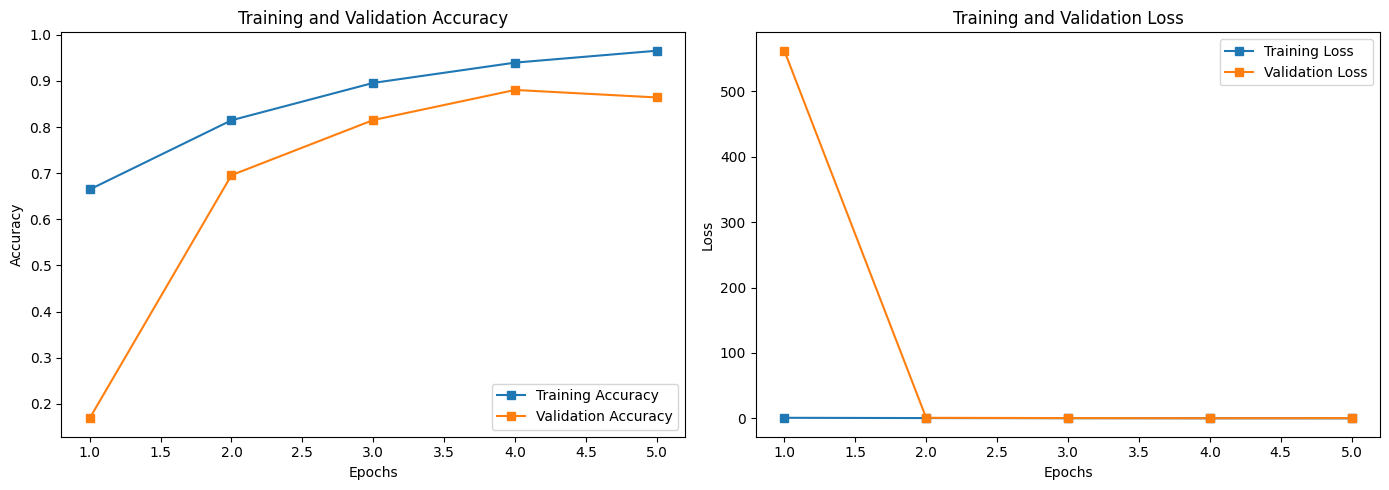

In [43]:
plot_training_history(history)

### Comment:

In [44]:
comment_model_name = "xception_short_train_frozen" # We re-define model name in this cell in case we want to update comment later
comments[comment_model_name] = \
f"""######## {comment_model_name}
• both, train and validation errors was aiming to good direction
• in last epoch we have validation accuracy drop
• It may be because too big learning rate
• it is still preffered to continue training and check what will happen
"""
print(comments[comment_model_name])

######## xception_short_train_frozen
• both, train and validation errors was aiming to good direction
• in last epoch we have validation accuracy drop
• It may be because too big learning rate
• it is still preffered to continue training and check what will happen



## Create, train and test xception_fine_tuned_from_frozen

In [45]:
for layer in base_model.layers:
    layer.trainable = True

In [46]:
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.01, momentum=0.9, decay=0.001) #We are changing learning rate to smaller value assuming that model is know more or less how our data looks like
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [47]:
model_name = "xception_fine_tuned_from_frozen"
training_start = datetime.now()
epochs = 10
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/10
86/86 [==============================] - 31s 321ms/step - loss: 0.0484 - accuracy: 0.9869 - val_loss: 0.2561 - val_accuracy: 0.9130
Epoch 2/10
86/86 [==============================] - 27s 312ms/step - loss: 0.0315 - accuracy: 0.9887 - val_loss: 0.2538 - val_accuracy: 0.9212
Epoch 3/10
86/86 [==============================] - 27s 312ms/step - loss: 0.0236 - accuracy: 0.9942 - val_loss: 0.2705 - val_accuracy: 0.9239
Epoch 4/10
86/86 [==============================] - 27s 312ms/step - loss: 0.0198 - accuracy: 0.9931 - val_loss: 0.2580 - val_accuracy: 0.9239
Epoch 5/10
86/86 [==============================] - 27s 313ms/step - loss: 0.0171 - accuracy: 0.9945 - val_loss: 0.2820 - val_accuracy: 0.9158
Epoch 6/10
86/86 [==============================] - 27s 315ms/step - loss: 0.0129 - accuracy: 0.9964 - val_loss: 0.3007 - val_accuracy: 0.9185
Epoch 7/10
86/86 [==============================] - 27s 315ms/step - loss: 0.0166 - accuracy: 0.9935 - val_loss: 0.3044 - val_accuracy: 0.9185

In [48]:
model.save(f'models/{model_name}.keras')

import pickle
with open(f'history/{model_name}_history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [49]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

summary[model_name] = {
    'accuracy':{
        'train':history.history['accuracy'][-1],
        'val':history.history['val_accuracy'][-1],
        'test':accuracy
    },
    'loss':{
        'train':history.history['loss'][-1],
        'val':history.history['val_loss'][-1],
        'test':loss
    },
    'epochs_of_training':epochs,
    'training_duration':(training_end - training_start).total_seconds()
}


18/18 [==============================] - 1s 69ms/step - loss: 0.2871 - accuracy: 0.9309
Test loss: 0.2870616912841797
Test accuracy: 0.9309090971946716


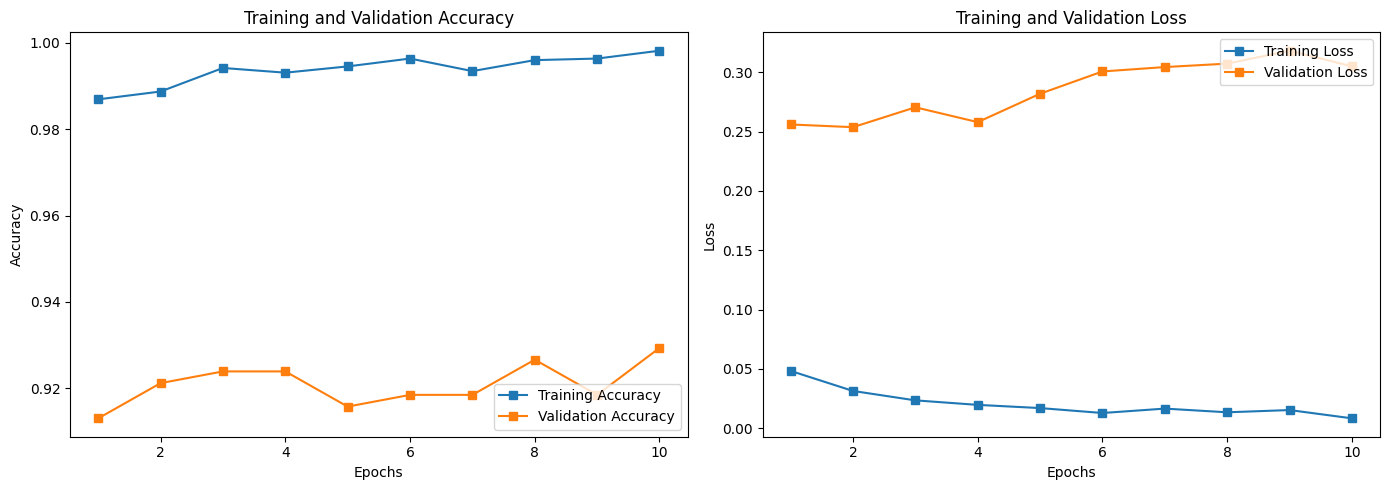

In [50]:
plot_training_history(history)

### Comment

In [51]:
comment_model_name = "xception_fine_tuned_from_frozen" # We re-define model name in this cell in case we want to update comment later
comments[comment_model_name] = \
f"""######## {comment_model_name}
• training acc is still improving while validation is not
• it suggestss overfitting
• reguralization is desired
• more augumented samples are also desired (as difference between validation and training is huge)
• it looks much worse than version trained on unfrozen base model which suggests that model is stucking in some local minimums on base_model layers
"""
print(comments[comment_model_name])

######## xception_fine_tuned_from_frozen
• training acc is still improving while validation is not
• it suggestss overfitting
• reguralization is desired
• more augumented samples are also desired (as difference between validation and training is huge)
• it looks much worse than version trained on unfrozen base model which suggests that model is stucking in some local minimums on base_model layers



# SUMMARISE PART

## Prepare data for summarisation

In [52]:
with open('data/summary.pickle', 'wb') as file:
    pickle.dump(summary, file)

In [53]:
summary

{'xception_untrained': {'accuracy': {'train': None,
   'val': None,
   'test': 0.2199999988079071},
  'loss': {'train': None, 'val': None, 'test': 1.6379731893539429},
  'epochs_of_training': 0,
  'training_duration': 0},
 'xception_short_train_unfrozen': {'accuracy': {'train': 0.9727470874786377,
   'val': 0.8994565010070801,
   'test': 0.9054545164108276},
  'loss': {'train': 0.0870312824845314,
   'val': 0.353229284286499,
   'test': 0.3107061982154846},
  'epochs_of_training': 5,
  'training_duration': 142.531627},
 'xception_short_train_frozen': {'accuracy': {'train': 0.9654796719551086,
   'val': 0.864130437374115,
   'test': 0.8509091138839722},
  'loss': {'train': 0.1058223769068718,
   'val': 0.457134872674942,
   'test': 0.47752559185028076},
  'epochs_of_training': 5,
  'training_duration': 139.589815},
 'xception_fine_tuned_from_unfrozen': {'accuracy': {'train': 0.9978197813034058,
   'val': 0.926630437374115,
   'test': 0.9272727370262146},
  'loss': {'train': 0.0086689498

In [54]:
# Just in case session was finished before summarising
import pickle
with open('data/summary.pickle', 'rb') as file:
    summary = pickle.load(file)

In [72]:
# prompt: Bazując na zawrtości "summary" przygotuj mi z tego dataframe. Chciałbym, żeby accuracy było rozdzielone na 3 kolumny (train, val, test)

import pandas as pd
# Rozpakowanie accuracy do osobnych kolumn
summary_expanded = {}
for model_name, data in summary.items():
  summary_expanded[model_name] = {
      'train_accuracy': data['accuracy']['train'],
      'val_accuracy': data['accuracy']['val'],
      'test_accuracy': data['accuracy']['test'],
      'epochs_of_training': data['epochs_of_training'],
      'training_duration': data['training_duration']
  }

# Tworzenie DataFrame
df = pd.DataFrame.from_dict(summary_expanded, orient='index')
# df.loc[df.index=='xception_short_train_frozen', 'epochs_of_training'] = 5 # Fixing mistake while saving summaries
df


train_accuracy  val_accuracy  \
xception_untrained                                  NaN           NaN   
xception_short_train_unfrozen                  0.972747      0.899457   
xception_short_train_frozen                    0.965480      0.864130   
xception_fine_tuned_from_unfrozen              0.997820      0.926630   
xception_fine_tuned_from_frozen                0.998183      0.929348   
xception_fine_tuned_from_frozen_dropout        0.996366      0.929348   

                                         test_accuracy  epochs_of_training  \
xception_untrained                            0.220000                   0   
xception_short_train_unfrozen                 0.905455                   5   
xception_short_train_frozen                   0.850909                   5   
xception_fine_tuned_from_unfrozen             0.927273                  10   
xception_fine_tuned_from_frozen               0.930909                  10   
xception_fine_tuned_from_frozen_dropout       0.925455                  10   

                                         training_duration  
xception_untrained                                0.000000  
xception_short_train_unfrozen                   142.531627  
xception_short_train_frozen                     139.589815  
xception_fine_tuned_from_unfrozen               270.378343  
xception_fine_tuned_from_frozen                 273.952811  
xception_fine_tuned_from_frozen_dropout         273.621460

In [73]:
# prompt: Update accuracy columns in df to display numbers in 00.00 format. Make sure that  None and NaN are still in orginal format

import pandas as pd
# Format accuracy columns to display numbers in 00.00 format
for col in ['train_accuracy', 'val_accuracy', 'test_accuracy']:
  df[col] = df[col].apply(lambda x: '{:.2f}'.format(x*100) if pd.notnull(x) else x)

print(df)

# prompt: bazując na zawartośći df, dodaj formatowanie warunkowe - chciałbym, żeby kolumny ACCURACY były w skali kolorów (wspólnej dla 3 kolumn) od czerwonego do zielonego. To ma być skala (gradient) od minimalnej wartości do maksymalnej, a nie kolorowanie warunkowe., a  żeby kolumna training_duration była formatowaniem warunkowym z "barami", tzn im dłuższy czas tym większy słupek
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
styled_df = df.style.background_gradient(cmap=cm, subset=['train_accuracy', 'val_accuracy', 'test_accuracy'], axis=0)\
                   .bar(subset=['training_duration'], color='#333399')


                                        train_accuracy val_accuracy  \
xception_untrained                                 NaN          NaN   
xception_short_train_unfrozen                    97.27        89.95   
xception_short_train_frozen                      96.55        86.41   
xception_fine_tuned_from_unfrozen                99.78        92.66   
xception_fine_tuned_from_frozen                  99.82        92.93   
xception_fine_tuned_from_frozen_dropout          99.64        92.93   

                                        test_accuracy  epochs_of_training  \
xception_untrained                              22.00                   0   
xception_short_train_unfrozen                   90.55                   5   
xception_short_train_frozen                     85.09                   5   
xception_fine_tuned_from_unfrozen               92.73                  10   
xception_fine_tuned_from_frozen                 93.09                  10   
xception_fine_tuned_from_frozen_dropout 

## Analyze results

In [75]:
display(styled_df)



 xception_fine_tuned_from_frozen_dropout


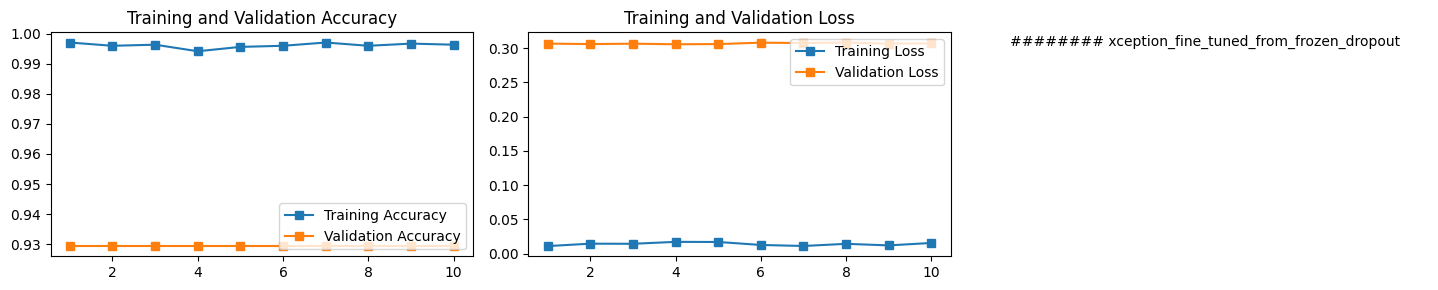


 xception_fine_tuned_from_frozen


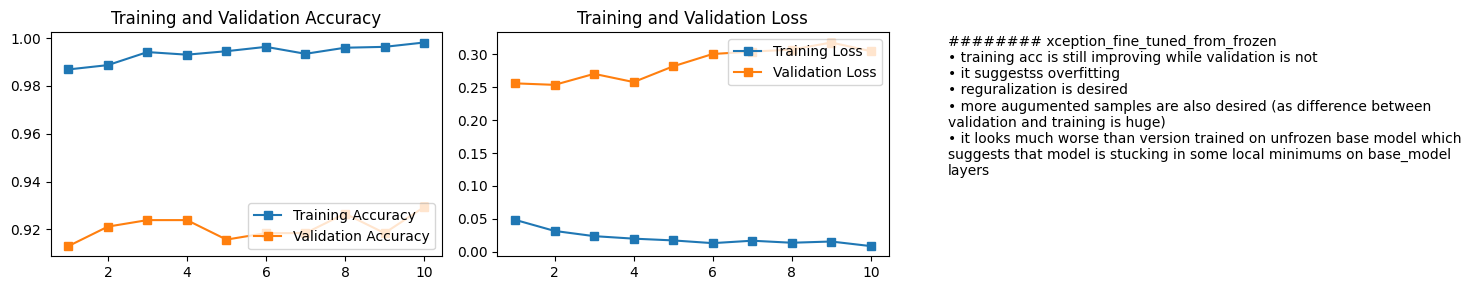


 xception_fine_tuned_from_unfrozen


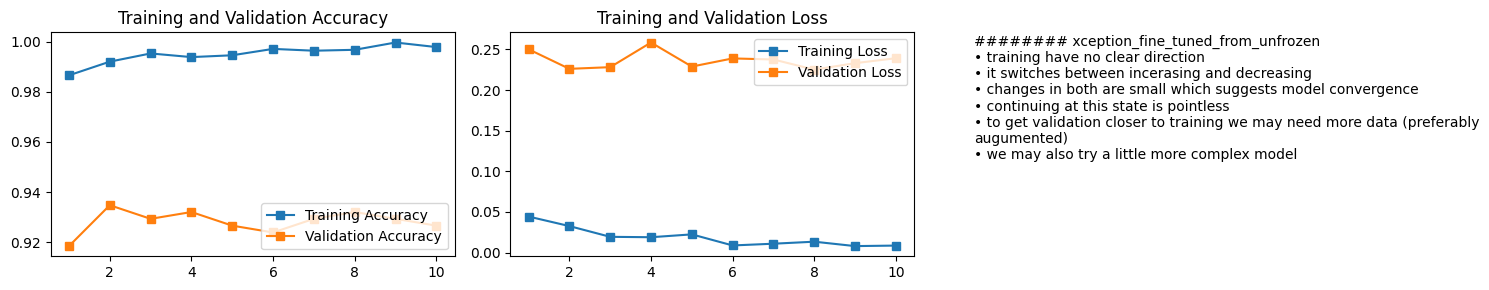


 xception_short_train_frozen


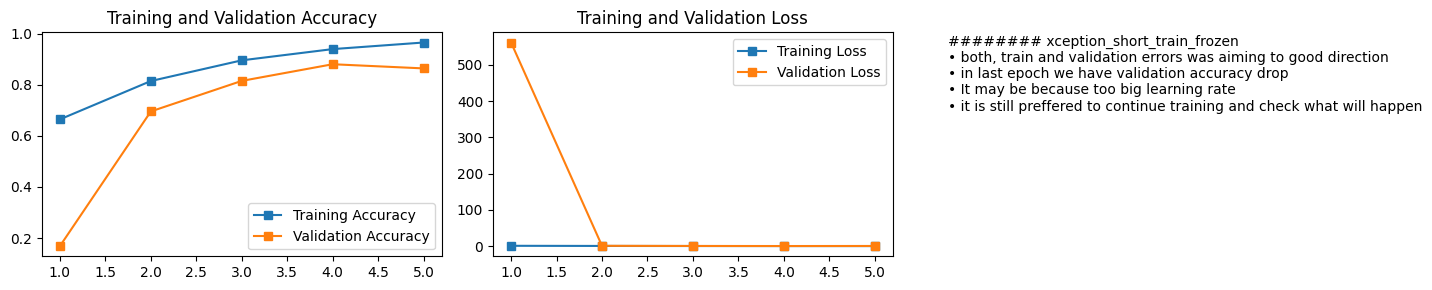


 xception_short_train_unfrozen


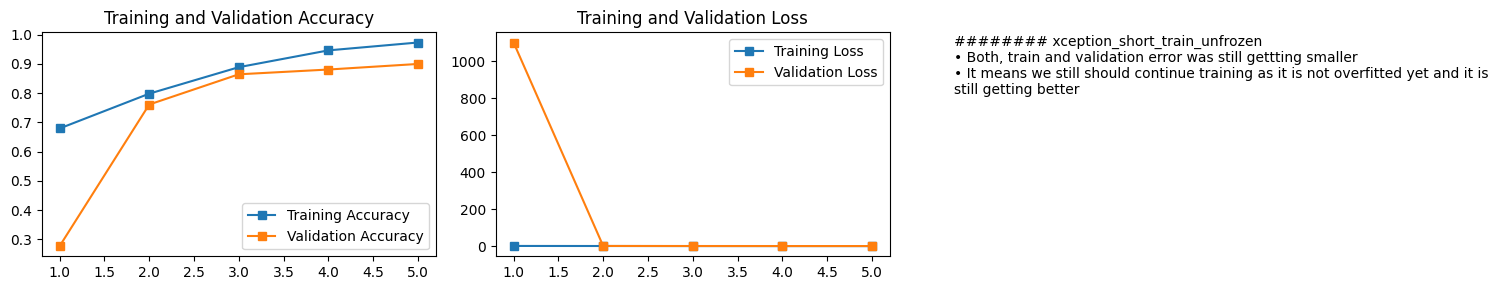

In [76]:
# prompt: In /history folder you have all histories objects saved as pickles, f.e "history/xception_short_train_frozen.pickle". I want you to open each of them and plot every using previously defined plot_training_history()

# comments['xception_short_train_unfrozen'] = \
# """- Both, train and validation error was still gettting smaller
# - It means we still should continue training as it is not overfitted yet and it is still getting better"""

import pickle
import os
import matplotlib.pyplot as plt

# Get a list of all pickle files in the 'history' folder
history_files = [f for f in os.listdir('history') if f.endswith('.pickle')]

# Iterate over each history file and plot its training history
for history_file in history_files:
  with open(os.path.join('history', history_file), 'rb') as file:
    history_data = pickle.load(file)

  # Assuming 'history_data' is in the format returned by model.fit()
  model_name = history_file.split("_history")[0]
  if model_name in comments:
    comment = comments[model_name]

  print("\n", model_name)
  plot_training_history_with_comment(history_data, comments[model_name], (15,3), name_labels=False)


# ADD REGURALIZATION TO IMPROVE MODEL:

In [32]:
train_set = tf.data.Dataset.load('data/train_set')
valid_set = tf.data.Dataset.load('data/valid_set')
test_set = tf.data.Dataset.load('data/test_set')

In [102]:
model = keras.models.load_model('models/xception_fine_tuned_from_frozen.keras')

## Add dropout in between without replacing dense layer

In [103]:
from keras.layers import Dropout

In [104]:
# for layer in model.layers[:-2]:
#   layer.trainable=False

In [105]:
model.layers[-5:]

In [106]:
x = model.layers[-2].output
x = keras.layers.Dropout(0.5)(x)  # Add Drouout layer right after GlobalAveragePooling2d
output = model.layers[-1](x) # And connect Dropout ouptut int last model layer
model = keras.models.Model(inputs=model.input, outputs=output)

In [107]:
model.layers[-5:]

In [108]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])


In [109]:
model_name = "xception_fine_tuned_from_frozen_dropout"
training_start = datetime.now()
epochs = 10
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/10
86/86 [==============================] - 30s 315ms/step - loss: 0.0102 - accuracy: 0.9964 - val_loss: 0.3077 - val_accuracy: 0.9293
Epoch 2/10
86/86 [==============================] - 26s 304ms/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 0.3087 - val_accuracy: 0.9293
Epoch 3/10
86/86 [==============================] - 26s 304ms/step - loss: 0.0118 - accuracy: 0.9978 - val_loss: 0.3093 - val_accuracy: 0.9293
Epoch 4/10
86/86 [==============================] - 26s 303ms/step - loss: 0.0134 - accuracy: 0.9967 - val_loss: 0.3096 - val_accuracy: 0.9293
Epoch 5/10
86/86 [==============================] - 26s 304ms/step - loss: 0.0103 - accuracy: 0.9975 - val_loss: 0.3099 - val_accuracy: 0.9293
Epoch 6/10
86/86 [==============================] - 26s 306ms/step - loss: 0.0088 - accuracy: 0.9989 - val_loss: 0.3097 - val_accuracy: 0.9293
Epoch 7/10
86/86 [==============================] - 26s 306ms/step - loss: 0.0106 - accuracy: 0.9975 - val_loss: 0.3100 - val_accuracy: 0.9266

In [110]:
model.save(f'models/{model_name}.keras')

import pickle
with open(f'history/{model_name}_history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [111]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

summary[model_name] = {
    'accuracy':{
        'train':history.history['accuracy'][-1],
        'val':history.history['val_accuracy'][-1],
        'test':accuracy
    },
    'loss':{
        'train':history.history['loss'][-1],
        'val':history.history['val_loss'][-1],
        'test':loss
    },
    'epochs_of_training':epochs,
    'training_duration':(training_end - training_start).total_seconds()
}


18/18 [==============================] - 1s 69ms/step - loss: 0.2955 - accuracy: 0.9255
Test loss: 0.29548847675323486
Test accuracy: 0.9254545569419861


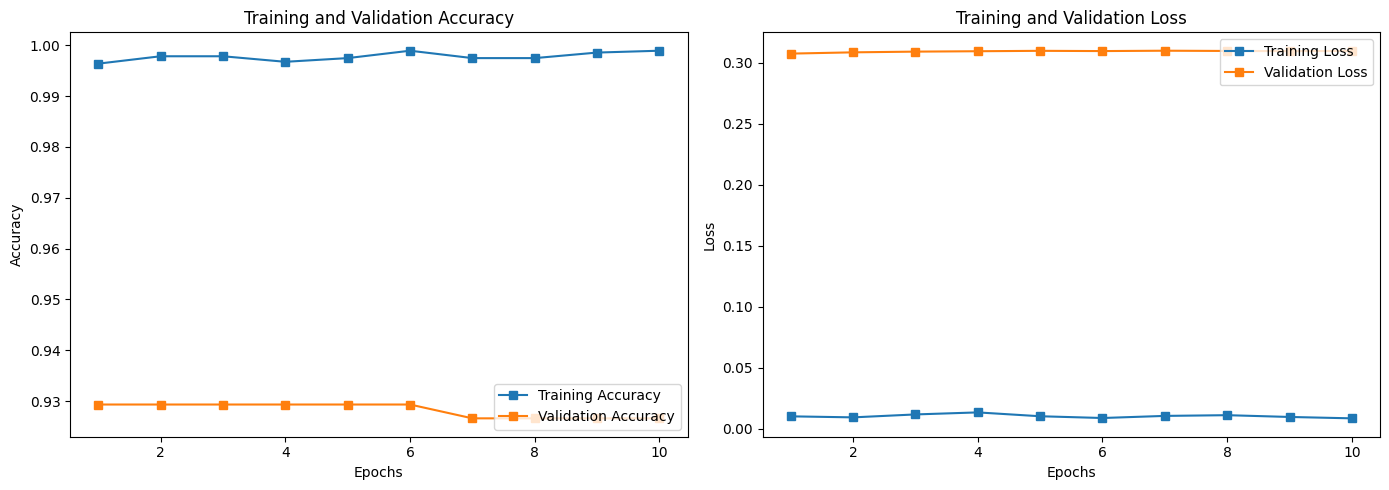

In [112]:
plot_training_history(history)

In [113]:
comment_model_name = "xception_fine_tuned_from_frozen_dropout" # We re-define model name in this cell in case we want to update comment later
comments[comment_model_name] = \
f"""######## {comment_model_name}
Model neither improving or getting worse here
"""
print(comments[comment_model_name])

######## xception_fine_tuned_from_frozen_dropout
Model neither improving or getting worse here



## Add dropout and replace tuned dense layer with new one (reset weights)

In [145]:
model = keras.models.load_model('models/xception_fine_tuned_from_frozen.keras')

In [146]:
x = model.layers[-2].output
x = keras.layers.Dropout(0.5)(x)  # Add Drouout layer right after GlobalAveragePooling2d
output = keras.layers.Dense(n_classes, activation="softmax")(x)
model = keras.models.Model(inputs=model.input, outputs=output)


In [147]:
for layer in model.layers[:-2]:
  layer.trainable=False

In [148]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])


In [149]:
model_name = "xception_fine_tuned_from_frozen_dropout2"
training_start = datetime.now()
epochs = 10
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/10
86/86 [==============================] - 10s 91ms/step - loss: 1.4547 - accuracy: 0.4582 - val_loss: 1.2849 - val_accuracy: 0.7310
Epoch 2/10
86/86 [==============================] - 7s 82ms/step - loss: 1.1172 - accuracy: 0.8136 - val_loss: 1.0289 - val_accuracy: 0.8940
Epoch 3/10
86/86 [==============================] - 7s 81ms/step - loss: 0.8610 - accuracy: 0.9589 - val_loss: 0.8521 - val_accuracy: 0.9103
Epoch 4/10
86/86 [==============================] - 7s 81ms/step - loss: 0.6913 - accuracy: 0.9884 - val_loss: 0.7299 - val_accuracy: 0.9130
Epoch 5/10
86/86 [==============================] - 7s 81ms/step - loss: 0.5717 - accuracy: 0.9935 - val_loss: 0.6431 - val_accuracy: 0.9130
Epoch 6/10
86/86 [==============================] - 7s 81ms/step - loss: 0.4863 - accuracy: 0.9971 - val_loss: 0.5795 - val_accuracy: 0.9130
Epoch 7/10
86/86 [==============================] - 7s 81ms/step - loss: 0.4194 - accuracy: 0.9982 - val_loss: 0.5314 - val_accuracy: 0.9158
Epoch 8/10
8

In [150]:
model.save(f'models/{model_name}.keras')

import pickle
with open(f'history/{model_name}_history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [151]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

summary[model_name] = {
    'accuracy':{
        'train':history.history['accuracy'][-1],
        'val':history.history['val_accuracy'][-1],
        'test':accuracy
    },
    'loss':{
        'train':history.history['loss'][-1],
        'val':history.history['val_loss'][-1],
        'test':loss
    },
    'epochs_of_training':epochs,
    'training_duration':(training_end - training_start).total_seconds()
}


18/18 [==============================] - 1s 69ms/step - loss: 0.4289 - accuracy: 0.9255
Test loss: 0.4289270341396332
Test accuracy: 0.9254545569419861


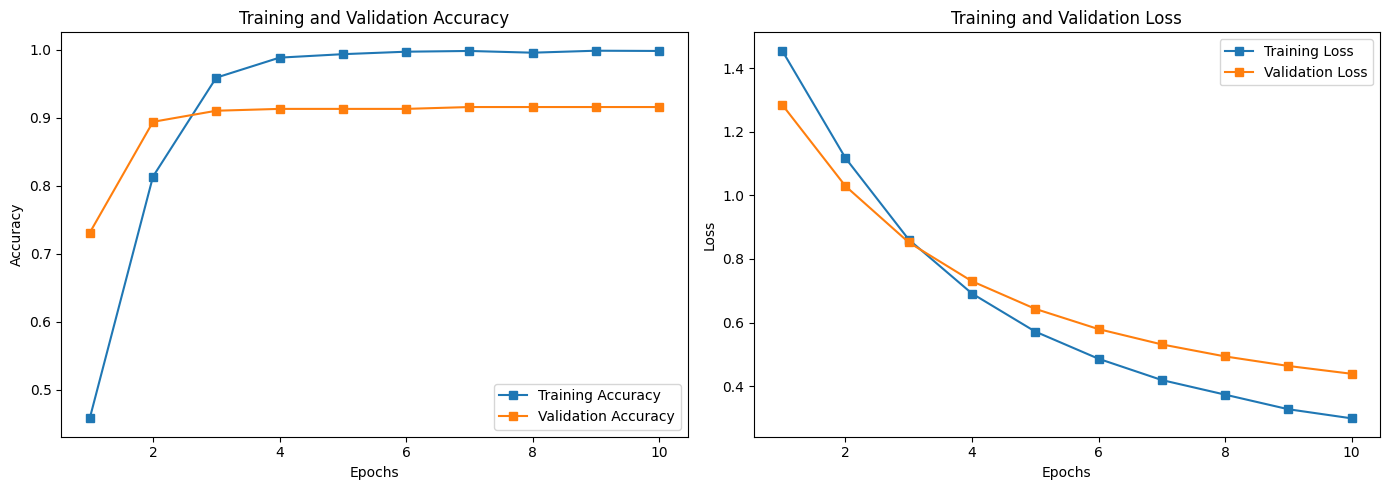

In [152]:
plot_training_history(history)

In [153]:
comment_model_name = "xception_fine_tuned_from_frozen_dropout2" # We re-define model name in this cell in case we want to update comment later
comments[comment_model_name] = \
f"""######## {comment_model_name}
Model neither improving or getting worse here
"""
print(comments[comment_model_name])

######## xception_fine_tuned_from_frozen_dropout2
Model neither improving or getting worse here



## Continue training as loss was still improving

In [154]:
model_name = "xception_fine_tuned_from_frozen_dropout2-2"
training_start = datetime.now()
epochs = 10
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/10
86/86 [==============================] - 7s 83ms/step - loss: 0.2773 - accuracy: 0.9978 - val_loss: 0.4184 - val_accuracy: 0.9158
Epoch 2/10
86/86 [==============================] - 7s 82ms/step - loss: 0.2523 - accuracy: 0.9989 - val_loss: 0.4012 - val_accuracy: 0.9158
Epoch 3/10
86/86 [==============================] - 7s 81ms/step - loss: 0.2327 - accuracy: 0.9985 - val_loss: 0.3865 - val_accuracy: 0.9158
Epoch 4/10
86/86 [==============================] - 7s 81ms/step - loss: 0.2182 - accuracy: 0.9989 - val_loss: 0.3738 - val_accuracy: 0.9158
Epoch 5/10
86/86 [==============================] - 7s 81ms/step - loss: 0.2057 - accuracy: 0.9985 - val_loss: 0.3627 - val_accuracy: 0.9158
Epoch 6/10
86/86 [==============================] - 7s 81ms/step - loss: 0.1937 - accuracy: 0.9985 - val_loss: 0.3529 - val_accuracy: 0.9158
Epoch 7/10
86/86 [==============================] - 7s 81ms/step - loss: 0.1795 - accuracy: 0.9989 - val_loss: 0.3443 - val_accuracy: 0.9158
Epoch 8/10
86

In [155]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


18/18 [==============================] - 1s 69ms/step - loss: 0.3136 - accuracy: 0.9327
Test loss: 0.3135756850242615
Test accuracy: 0.9327272772789001


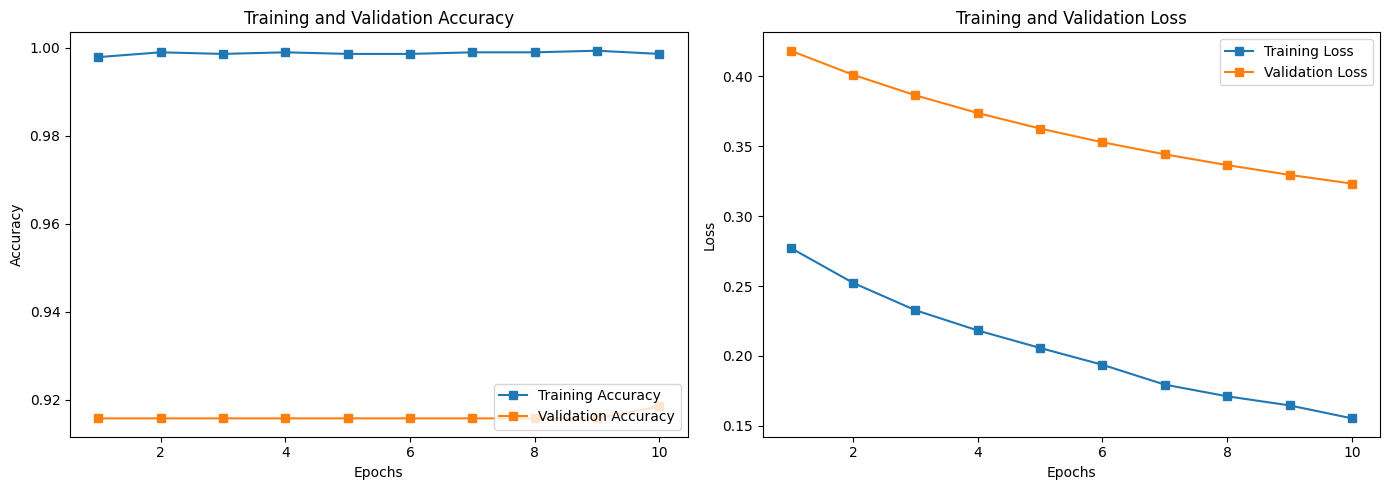

In [156]:
plot_training_history(history)

#### We have best model until now (93,27%) and still progressing, but validation ass is not improving much so lets explore other methods

## Try DROPOUT and L2 REGURALIZATION

As we can't get closer to training accuracy on our valid dataset - we have weak generalization ability

In [157]:
model = keras.models.load_model('models/xception_fine_tuned_from_frozen.keras')

In [158]:
for layer in model.layers[:-2]:
  layer.trainable=False

In [159]:
from tensorflow.keras.regularizers import l2
x = model.layers[-2].output
x = keras.layers.Dropout(0.5)(x)  # Add Drouout layer right after GlobalAveragePooling2d
output = keras.layers.Dense(n_classes, activation="softmax",
                            kernel_regularizer=l2(0.05),
                            bias_regularizer=l2(0.05))(x)
model = keras.models.Model(inputs=model.input, outputs=output)


In [160]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [161]:
model_name = "xception_fine_tuned_from_frozen_dropout2_with_l2"
training_start = datetime.now()
epochs = 20
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/20
86/86 [==============================] - 10s 91ms/step - loss: 1.8701 - accuracy: 0.5138 - val_loss: 1.6907 - val_accuracy: 0.8505
Epoch 2/20
86/86 [==============================] - 7s 81ms/step - loss: 1.5360 - accuracy: 0.8783 - val_loss: 1.4630 - val_accuracy: 0.9103
Epoch 3/20
86/86 [==============================] - 7s 81ms/step - loss: 1.3098 - accuracy: 0.9764 - val_loss: 1.3051 - val_accuracy: 0.9239
Epoch 4/20
86/86 [==============================] - 7s 81ms/step - loss: 1.1478 - accuracy: 0.9895 - val_loss: 1.1947 - val_accuracy: 0.9158
Epoch 5/20
86/86 [==============================] - 7s 81ms/step - loss: 1.0375 - accuracy: 0.9953 - val_loss: 1.1148 - val_accuracy: 0.9158
Epoch 6/20
86/86 [==============================] - 7s 81ms/step - loss: 0.9601 - accuracy: 0.9945 - val_loss: 1.0548 - val_accuracy: 0.9185
Epoch 7/20
86/86 [==============================] - 7s 81ms/step - loss: 0.8948 - accuracy: 0.9956 - val_loss: 1.0082 - val_accuracy: 0.9185
Epoch 8/20
8

In [162]:
model.save(f'models/{model_name}.keras')

import pickle
with open(f'history/{model_name}_history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [163]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

summary[model_name] = {
    'accuracy':{
        'train':history.history['accuracy'][-1],
        'val':history.history['val_accuracy'][-1],
        'test':accuracy
    },
    'loss':{
        'train':history.history['loss'][-1],
        'val':history.history['val_loss'][-1],
        'test':loss
    },
    'epochs_of_training':epochs,
    'training_duration':(training_end - training_start).total_seconds()
}


18/18 [==============================] - 1s 69ms/step - loss: 0.7585 - accuracy: 0.9345
Test loss: 0.758470892906189
Test accuracy: 0.9345454573631287


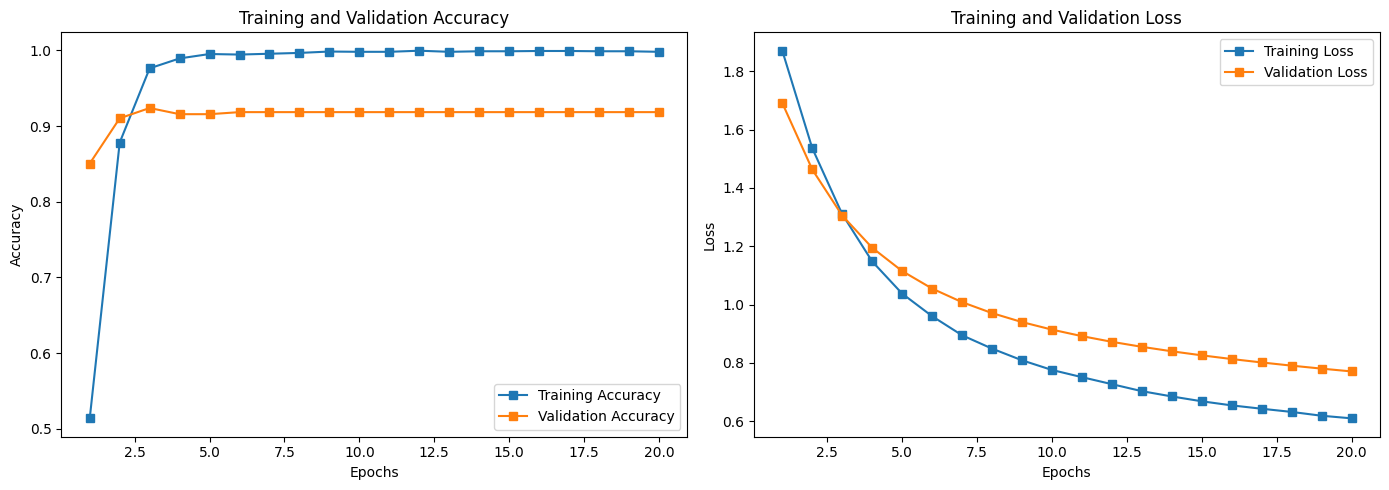

In [164]:
plot_training_history(history)

In [165]:
comment_model_name = "xception_fine_tuned_from_frozen_dropout2" # We re-define model name in this cell in case we want to update comment later
comments[comment_model_name] = \
f"""######## {comment_model_name}
Model neither improving or getting worse here
"""
print(comments[comment_model_name])

######## xception_fine_tuned_from_frozen_dropout2
Model neither improving or getting worse here



In [166]:
summary

{'xception_untrained': {'accuracy': {'train': None,
   'val': None,
   'test': 0.2199999988079071},
  'loss': {'train': None, 'val': None, 'test': 1.6379731893539429},
  'epochs_of_training': 0,
  'training_duration': 0},
 'xception_short_train_unfrozen': {'accuracy': {'train': 0.9727470874786377,
   'val': 0.8994565010070801,
   'test': 0.9054545164108276},
  'loss': {'train': 0.0870312824845314,
   'val': 0.353229284286499,
   'test': 0.3107061982154846},
  'epochs_of_training': 5,
  'training_duration': 142.531627},
 'xception_short_train_frozen': {'accuracy': {'train': 0.9654796719551086,
   'val': 0.864130437374115,
   'test': 0.8509091138839722},
  'loss': {'train': 0.1058223769068718,
   'val': 0.457134872674942,
   'test': 0.47752559185028076},
  'epochs_of_training': 5,
  'training_duration': 139.589815},
 'xception_fine_tuned_from_unfrozen': {'accuracy': {'train': 0.9978197813034058,
   'val': 0.926630437374115,
   'test': 0.9272727370262146},
  'loss': {'train': 0.0086689498

## Try DROPOUT and L2 REGURALIZATION without locking layers

As we can't get closer to training accuracy on our valid dataset - we have weak generalization ability

In [167]:
model = keras.models.load_model('models/xception_fine_tuned_from_frozen.keras')

In [168]:
for layer in model.layers[:]:
  layer.trainable=True

In [ ]:
from tensorflow.keras.regularizers import l2
x = model.layers[-2].output
x = keras.layers.Dropout(0.5)(x)  # Add Drouout layer right after GlobalAveragePooling2d
output = keras.layers.Dense(n_classes, activation="softmax",
                            kernel_regularizer=l2(0.05),
                            bias_regularizer=l2(0.05))(x)
model = keras.models.Model(inputs=model.input, outputs=output)


In [169]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [170]:
model_name = "xception_fine_tuned_from_frozen_dropout2_with_l2_no_freezing"
training_start = datetime.now()
epochs = 20
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/20
86/86 [==============================] - 31s 319ms/step - loss: 0.0074 - accuracy: 0.9989 - val_loss: 0.3075 - val_accuracy: 0.9293
Epoch 2/20
86/86 [==============================] - 27s 316ms/step - loss: 0.0073 - accuracy: 0.9993 - val_loss: 0.3086 - val_accuracy: 0.9293
Epoch 3/20
86/86 [==============================] - 27s 311ms/step - loss: 0.0071 - accuracy: 0.9993 - val_loss: 0.3090 - val_accuracy: 0.9293
Epoch 4/20
86/86 [==============================] - 27s 308ms/step - loss: 0.0070 - accuracy: 0.9993 - val_loss: 0.3092 - val_accuracy: 0.9293
Epoch 5/20
86/86 [==============================] - 26s 305ms/step - loss: 0.0069 - accuracy: 0.9993 - val_loss: 0.3093 - val_accuracy: 0.9266
Epoch 6/20
86/86 [==============================] - 27s 308ms/step - loss: 0.0068 - accuracy: 0.9993 - val_loss: 0.3093 - val_accuracy: 0.9266
Epoch 7/20
86/86 [==============================] - 27s 309ms/step - loss: 0.0066 - accuracy: 0.9993 - val_loss: 0.3093 - val_accuracy: 0.9266

In [171]:
model.save(f'models/{model_name}.keras')

import pickle
with open(f'history/{model_name}_history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [172]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

summary[model_name] = {
    'accuracy':{
        'train':history.history['accuracy'][-1],
        'val':history.history['val_accuracy'][-1],
        'test':accuracy
    },
    'loss':{
        'train':history.history['loss'][-1],
        'val':history.history['val_loss'][-1],
        'test':loss
    },
    'epochs_of_training':epochs,
    'training_duration':(training_end - training_start).total_seconds()
}


18/18 [==============================] - 1s 69ms/step - loss: 0.2958 - accuracy: 0.9255
Test loss: 0.2957562506198883
Test accuracy: 0.9254545569419861


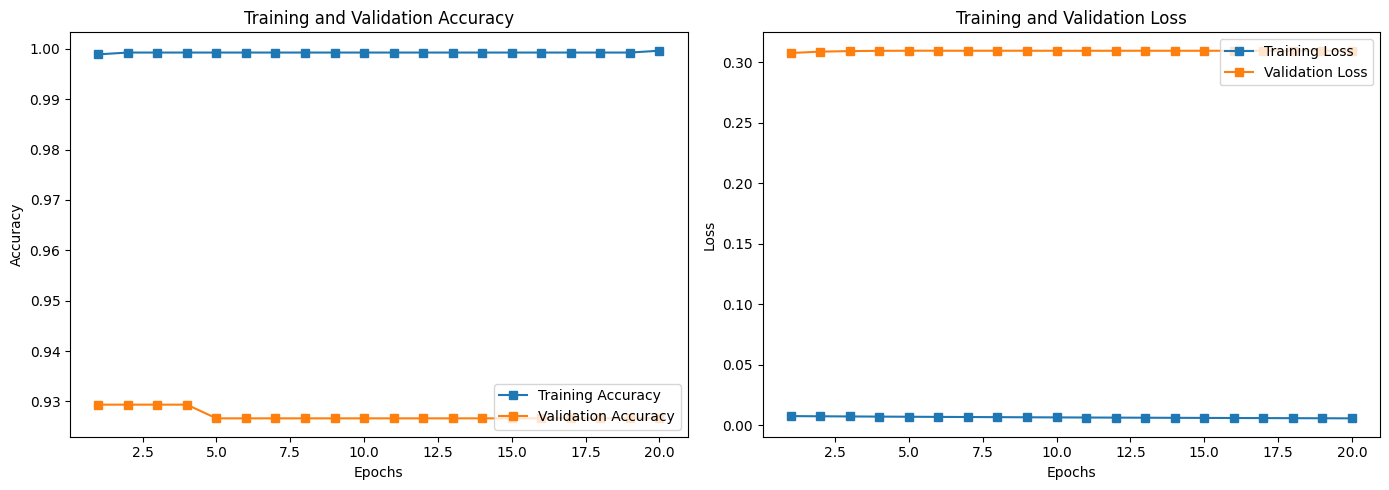

In [173]:
plot_training_history(history)

In [ ]:
comment_model_name = "xception_fine_tuned_from_frozen_dropout2_with_l2_no_freezing" # We re-define model name in this cell in case we want to update comment later
comments[comment_model_name] = \
f"""######## {comment_model_name}
Model neither improving or getting worse here
"""
print(comments[comment_model_name])

######## xception_fine_tuned_from_frozen_dropout2
Model neither improving or getting worse here



In [174]:
summary

{'xception_untrained': {'accuracy': {'train': None,
   'val': None,
   'test': 0.2199999988079071},
  'loss': {'train': None, 'val': None, 'test': 1.6379731893539429},
  'epochs_of_training': 0,
  'training_duration': 0},
 'xception_short_train_unfrozen': {'accuracy': {'train': 0.9727470874786377,
   'val': 0.8994565010070801,
   'test': 0.9054545164108276},
  'loss': {'train': 0.0870312824845314,
   'val': 0.353229284286499,
   'test': 0.3107061982154846},
  'epochs_of_training': 5,
  'training_duration': 142.531627},
 'xception_short_train_frozen': {'accuracy': {'train': 0.9654796719551086,
   'val': 0.864130437374115,
   'test': 0.8509091138839722},
  'loss': {'train': 0.1058223769068718,
   'val': 0.457134872674942,
   'test': 0.47752559185028076},
  'epochs_of_training': 5,
  'training_duration': 139.589815},
 'xception_fine_tuned_from_unfrozen': {'accuracy': {'train': 0.9978197813034058,
   'val': 0.926630437374115,
   'test': 0.9272727370262146},
  'loss': {'train': 0.0086689498

# MAKE CHANGES TO ARCHITECTURE

## skip last 13 layers (Assuming network is to complex to generalize)

In [226]:
model = keras.models.load_model('models/xception_fine_tuned_from_frozen.keras')

In [227]:
len(model.layers)

134

In [228]:
model.layers[-20:] # lets skip last convo, normalization and core layers and recreate avg and dense with reguralization

In [229]:
model.layers[-13]

In [230]:
from tensorflow.keras.regularizers import l2
x = model.layers[-13].output
x = keras.layers.GlobalAveragePooling2D()(x) #We want to add them manually so we can train them
x = keras.layers.Dropout(0.5)(x)  # Add Drouout layer right after GlobalAveragePooling2d
output = keras.layers.Dense(n_classes, activation="softmax",
                            kernel_regularizer=l2(0.05),
                            bias_regularizer=l2(0.05))(x)
model = keras.models.Model(inputs=model.input, outputs=output)


In [231]:
len(model.layers)

125

In [232]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [233]:
model_name = "xception_fine_tuned_from_frozen_dropout2_with_l2_no_freezing_skip_last_cnn"
training_start = datetime.now()
epochs = 20
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/20


86/86 [==============================] - 30s 314ms/step - loss: 1.6528 - accuracy: 0.5429 - val_loss: 1.3602 - val_accuracy: 0.8071
Epoch 2/20
86/86 [==============================] - 26s 301ms/step - loss: 1.2091 - accuracy: 0.8289 - val_loss: 1.1272 - val_accuracy: 0.8723
Epoch 3/20
86/86 [==============================] - 26s 300ms/step - loss: 1.0235 - accuracy: 0.8972 - val_loss: 1.0056 - val_accuracy: 0.8886
Epoch 4/20
86/86 [==============================] - 26s 300ms/step - loss: 0.9017 - accuracy: 0.9255 - val_loss: 0.9324 - val_accuracy: 0.8940
Epoch 5/20
86/86 [==============================] - 26s 300ms/step - loss: 0.8333 - accuracy: 0.9430 - val_loss: 0.8822 - val_accuracy: 0.8967
Epoch 6/20
86/86 [==============================] - 26s 299ms/step - loss: 0.7759 - accuracy: 0.9560 - val_loss: 0.8455 - val_accuracy: 0.8967
Epoch 7/20
86/86 [==============================] - 26s 300ms/step - loss: 0.7393 - accuracy: 0.9618 - val_loss: 0.8173 - val_accuracy: 0.8995
Epoch 8/20

In [234]:
model.save(f'models/{model_name}.keras')

import pickle
with open(f'history/{model_name}_history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [235]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

summary[model_name] = {
    'accuracy':{
        'train':history.history['accuracy'][-1],
        'val':history.history['val_accuracy'][-1],
        'test':accuracy
    },
    'loss':{
        'train':history.history['loss'][-1],
        'val':history.history['val_loss'][-1],
        'test':loss
    },
    'epochs_of_training':epochs,
    'training_duration':(training_end - training_start).total_seconds()
}


18/18 [==============================] - 1s 68ms/step - loss: 0.6325 - accuracy: 0.9382
Test loss: 0.6325476169586182
Test accuracy: 0.9381818175315857


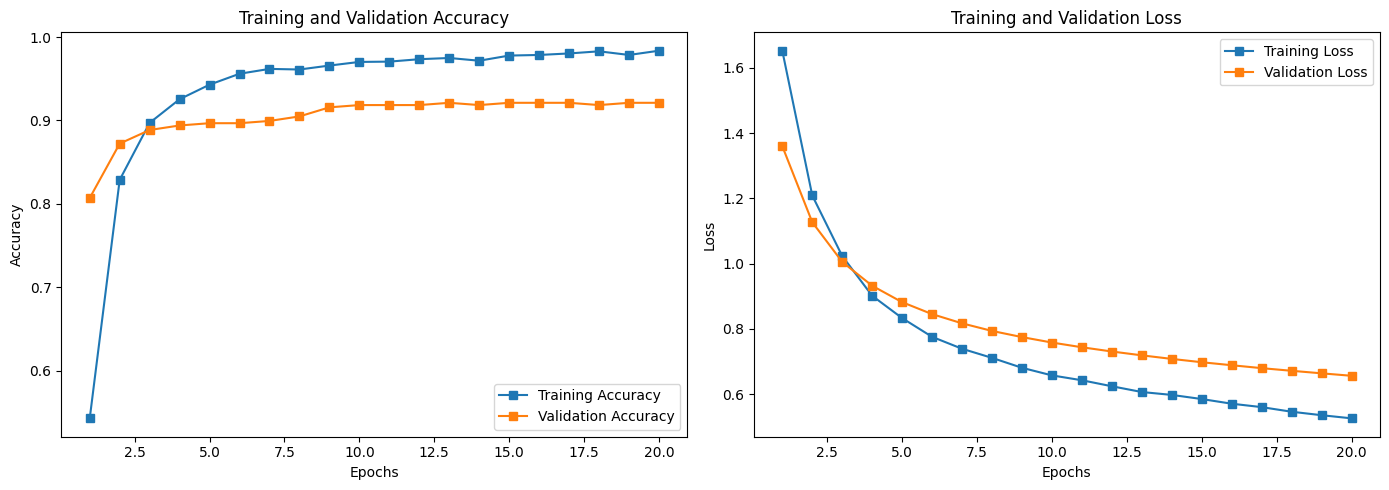

In [236]:
plot_training_history(history)

## skip last 63 layers (Assuming network is to complex to generalize)

In [ ]:
model = keras.models.load_model('models/xception_fine_tuned_from_frozen.keras')

In [ ]:
len(model.layers)

134

In [ ]:
model.layers[-70:-60] # lets skip last convo, normalization and core layers and recreate avg and dense with reguralization

In [ ]:
model.layers[-63]

In [ ]:
from tensorflow.keras.regularizers import l2
x = model.layers[-63].output
x = keras.layers.GlobalAveragePooling2D()(x) #We want to add them manually so we can train them
x = keras.layers.Dropout(0.5)(x)  # Add Drouout layer right after GlobalAveragePooling2d
output = keras.layers.Dense(n_classes, activation="softmax",
                            kernel_regularizer=l2(0.05),
                            bias_regularizer=l2(0.05))(x)
model = keras.models.Model(inputs=model.input, outputs=output)


In [ ]:
len(model.layers)

75

In [ ]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
model_name = "xception_fine_tuned_from_frozen_dropout2_with_l2_no_freezing_half_network"
training_start = datetime.now()
epochs = 40
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/40
86/86 [==============================] - 22s 239ms/step - loss: 2.6790 - accuracy: 0.2049 - val_loss: 2.0359 - val_accuracy: 0.2473
Epoch 2/40
86/86 [==============================] - 20s 233ms/step - loss: 2.5209 - accuracy: 0.2358 - val_loss: 1.9018 - val_accuracy: 0.4212
Epoch 3/40
86/86 [==============================] - 21s 243ms/step - loss: 2.3704 - accuracy: 0.2718 - val_loss: 1.7861 - val_accuracy: 0.4918
Epoch 4/40
86/86 [==============================] - 20s 232ms/step - loss: 2.2818 - accuracy: 0.2809 - val_loss: 1.6798 - val_accuracy: 0.5761
Epoch 5/40
86/86 [==============================] - 21s 240ms/step - loss: 2.1188 - accuracy: 0.3292 - val_loss: 1.6088 - val_accuracy: 0.5951
Epoch 6/40
86/86 [==============================] - 20s 231ms/step - loss: 2.0402 - accuracy: 0.3725 - val_loss: 1.5487 - val_accuracy: 0.5951
Epoch 7/40
86/86 [==============================] - 20s 231ms/step - loss: 1.9409 - accuracy: 0.4004 - val_loss: 1.4844 - val_accuracy: 0.6332

In [ ]:
model.save(f'models/{model_name}.keras')

import pickle
with open(f'history/{model_name}_history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

summary[model_name] = {
    'accuracy':{
        'train':history.history['accuracy'][-1],
        'val':history.history['val_accuracy'][-1],
        'test':accuracy
    },
    'loss':{
        'train':history.history['loss'][-1],
        'val':history.history['val_loss'][-1],
        'test':loss
    },
    'epochs_of_training':epochs,
    'training_duration':(training_end - training_start).total_seconds()
}


18/18 [==============================] - 1s 54ms/step - loss: 0.7848 - accuracy: 0.8309
Test loss: 0.7847643494606018
Test accuracy: 0.8309090733528137


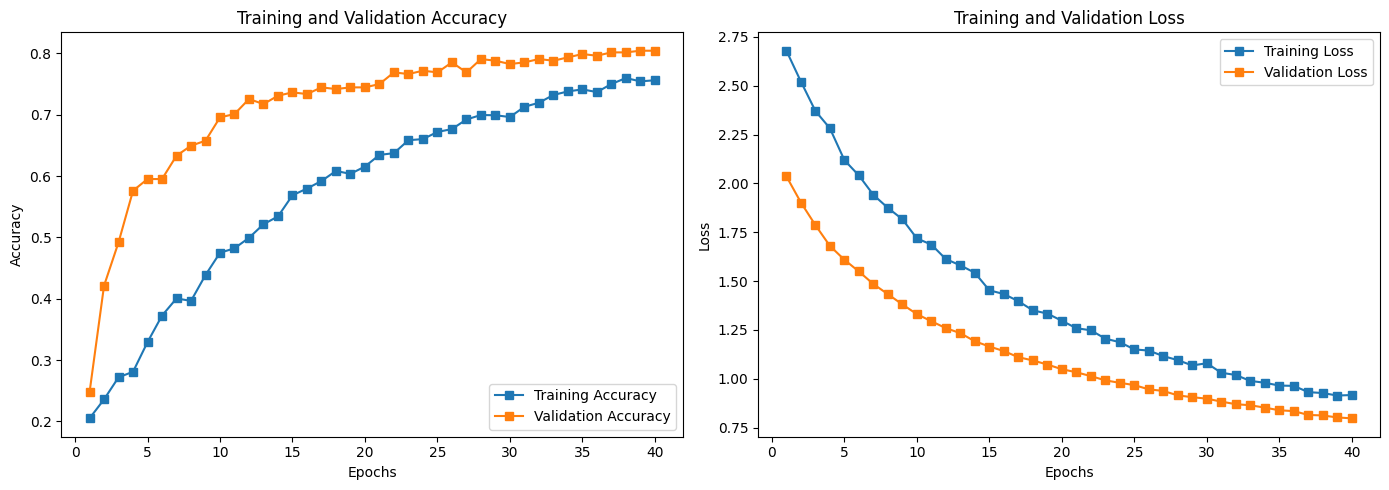

In [ ]:
plot_training_history(history)

## skip last 63 layers, try bigger LR (assuming model have not enough time to adapt) 

In [270]:
model = keras.models.load_model('models/xception_fine_tuned_from_frozen.keras')

In [271]:
len(model.layers)

134

In [272]:
model.layers[-70:-60] # lets skip last convo, normalization and core layers and recreate avg and dense with reguralization

In [273]:
model.layers[-63]

In [274]:
from tensorflow.keras.regularizers import l2
x = model.layers[-63].output
x = keras.layers.GlobalAveragePooling2D()(x) #We want to add them manually so we can train them
x = keras.layers.Dropout(0.5)(x)  # Add Drouout layer right after GlobalAveragePooling2d
output = keras.layers.Dense(n_classes, activation="softmax",
                            kernel_regularizer=l2(0.05),
                            bias_regularizer=l2(0.05))(x)
model = keras.models.Model(inputs=model.input, outputs=output)


In [275]:
len(model.layers)

75

In [276]:
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.02, momentum=0.9, decay=0.01) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [277]:
model_name = "xception_fine_tuned_from_frozen_dropout2_with_l2_no_freezing_half_network"
training_start = datetime.now()
epochs = 40
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/40
86/86 [==============================] - 23s 244ms/step - loss: 2.0699 - accuracy: 0.6290 - val_loss: 1.0915 - val_accuracy: 0.8315
Epoch 2/40
86/86 [==============================] - 20s 238ms/step - loss: 0.7193 - accuracy: 0.8685 - val_loss: 0.6976 - val_accuracy: 0.8587
Epoch 3/40
86/86 [==============================] - 20s 237ms/step - loss: 0.3631 - accuracy: 0.9342 - val_loss: 0.4658 - val_accuracy: 0.8859
Epoch 4/40
86/86 [==============================] - 20s 238ms/step - loss: 0.2775 - accuracy: 0.9502 - val_loss: 0.3674 - val_accuracy: 0.9185
Epoch 5/40
86/86 [==============================] - 20s 237ms/step - loss: 0.2214 - accuracy: 0.9677 - val_loss: 0.3561 - val_accuracy: 0.9266
Epoch 6/40
86/86 [==============================] - 21s 238ms/step - loss: 0.1955 - accuracy: 0.9753 - val_loss: 0.3512 - val_accuracy: 0.9348
Epoch 7/40
86/86 [==============================] - 21s 238ms/step - loss: 0.1799 - accuracy: 0.9786 - val_loss: 0.3379 - val_accuracy: 0.9212

In [278]:
model.save(f'models/{model_name}.keras')

import pickle
with open(f'history/{model_name}_history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [279]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

summary[model_name] = {
    'accuracy':{
        'train':history.history['accuracy'][-1],
        'val':history.history['val_accuracy'][-1],
        'test':accuracy
    },
    'loss':{
        'train':history.history['loss'][-1],
        'val':history.history['val_loss'][-1],
        'test':loss
    },
    'epochs_of_training':epochs,
    'training_duration':(training_end - training_start).total_seconds()
}


18/18 [==============================] - 1s 55ms/step - loss: 0.3126 - accuracy: 0.9182
Test loss: 0.3126041293144226
Test accuracy: 0.918181836605072


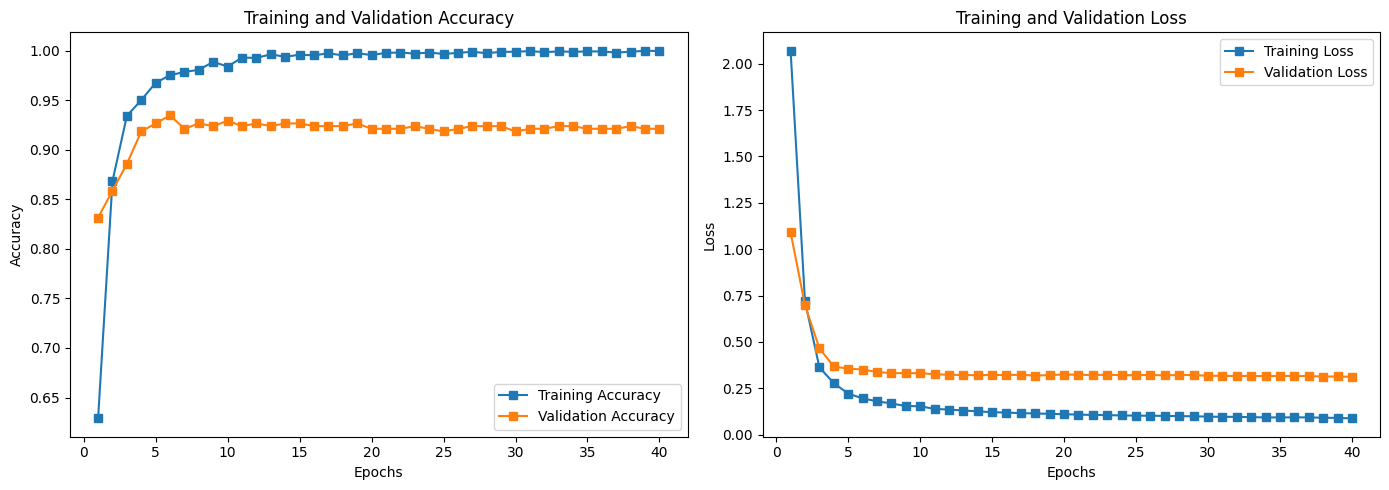

In [280]:
plot_training_history(history)

# TRY DIFFERENT ARCHITECTURE (if even cutting-out of half xception is still too complex)
If i am cutting bigger-and-bigger part xception maybe it is worth to try from scratch

## inspired start of xception 

In [ ]:
model = keras.models.load_model('models/xception_fine_tuned_from_frozen.keras')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, SeparableConv2D, GlobalAveragePooling2D, Dense

# Define input shape
input_shape = (224, 224, 3)  # Adjust according to your image dimensions

# Create the model
inputs = Input(shape=input_shape)

x = Conv2D(filters=32, kernel_size=3, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = SeparableConv2D(filters=64, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = GlobalAveragePooling2D()(x)

# Lets start with no reguralization
# x = keras.layers.Dropout(0.5)(x)  
output = keras.layers.Dense(n_classes, activation="softmax",
                            # kernel_regularizer=l2(0.05),
                            # bias_regularizer=l2(0.05)
                            )(x)

model = keras.models.Model(inputs=inputs, outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.02, momentum=0.9, decay=0.01) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

model.summary()



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_26 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization_27 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                          

c:\PythonScripts\image_classification\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model_name = "network_from_scratch"
training_start = datetime.now()
epochs = 40
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/40


86/86 [==============================] - 22s 226ms/step - loss: 1.2933 - accuracy: 0.4626 - val_loss: 1.4296 - val_accuracy: 0.3940
Epoch 2/40
86/86 [==============================] - 20s 230ms/step - loss: 1.1963 - accuracy: 0.5124 - val_loss: 1.3202 - val_accuracy: 0.4592
Epoch 3/40
86/86 [==============================] - 19s 218ms/step - loss: 1.1489 - accuracy: 0.5356 - val_loss: 1.2394 - val_accuracy: 0.5082
Epoch 4/40
86/86 [==============================] - 19s 218ms/step - loss: 1.1223 - accuracy: 0.5501 - val_loss: 1.1958 - val_accuracy: 0.5272
Epoch 5/40
86/86 [==============================] - 19s 218ms/step - loss: 1.1002 - accuracy: 0.5538 - val_loss: 1.1244 - val_accuracy: 0.5625
Epoch 6/40
86/86 [==============================] - 19s 218ms/step - loss: 1.0830 - accuracy: 0.5603 - val_loss: 1.0936 - val_accuracy: 0.5924
Epoch 7/40
86/86 [==============================] - 19s 218ms/step - loss: 1.0661 - accuracy: 0.5650 - val_loss: 1.0766 - val_accuracy: 0.6114
Epoch 8/40

In [ ]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

18/18 [==============================] - 1s 48ms/step - loss: 0.9163 - accuracy: 0.6400
Test loss: 0.9163222908973694
Test accuracy: 0.6399999856948853


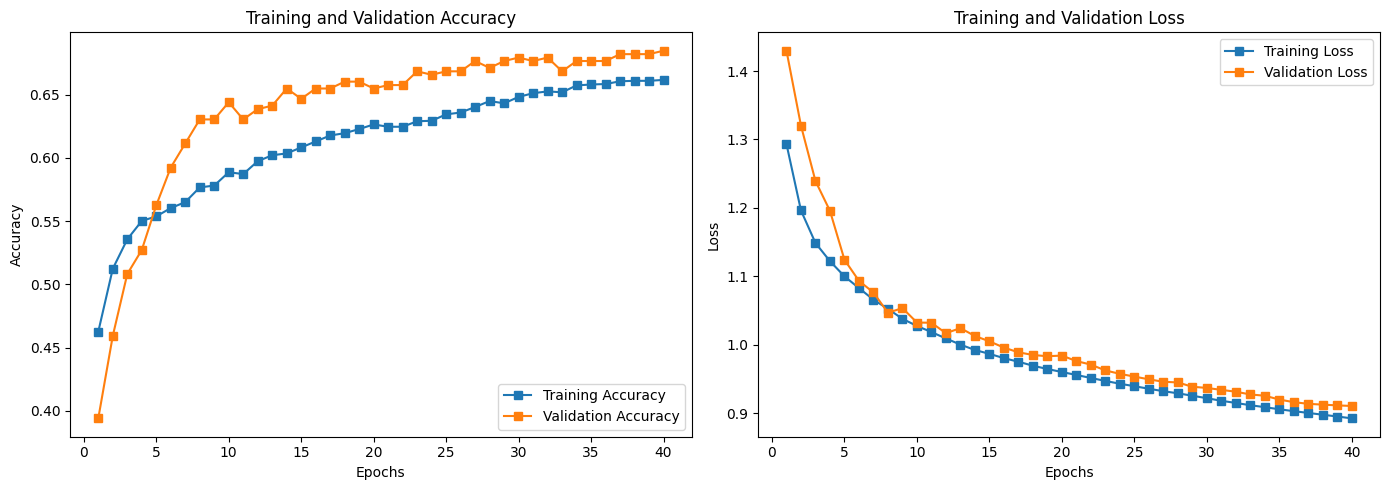

In [ ]:
plot_training_history(history)

## some basic conv2d layers connected

In [38]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, SeparableConv2D, GlobalAveragePooling2D, Dense, MaxPooling2D, Dropout

# Define input shape
input_shape = (224, 224, 3)  # Adjust according to your image dimensions

# Create the model
inputs = Input(shape=input_shape)

x = Conv2D(32, 3, padding='same', activation='relu')(inputs) # Start with smaller layers to reckognize simple patterns
x = BatchNormalization()(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x) 
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(64, 3, padding='same', activation='relu')(x) # Then make it bigger to udnerstand more complex one
x = BatchNormalization()(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)  
x = MaxPooling2D()(x)

x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Lets start with no reguralization
# x = keras.layers.Dropout(0.5)(x)  
output = keras.layers.Dense(n_classes, activation="softmax",
                            # kernel_regularizer=l2(0.05),
                            # bias_regularizer=l2(0.05)
                            )(x)

model = keras.models.Model(inputs=inputs, outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.02, momentum=0.9, decay=0.01) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_20 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_21 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0   

In [39]:
model_name = "network_from_scratch1"
training_start = datetime.now()
epochs = 40
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/40
86/86 [==============================] - 19s 169ms/step - loss: 1.2695 - accuracy: 0.4727 - val_loss: 1.4275 - val_accuracy: 0.3886
Epoch 2/40
86/86 [==============================] - 14s 159ms/step - loss: 1.0887 - accuracy: 0.5636 - val_loss: 1.2338 - val_accuracy: 0.5190
Epoch 3/40
86/86 [==============================] - 14s 158ms/step - loss: 0.9861 - accuracy: 0.6195 - val_loss: 1.2518 - val_accuracy: 0.5190
Epoch 4/40
86/86 [==============================] - 14s 158ms/step - loss: 0.9125 - accuracy: 0.6483 - val_loss: 1.0901 - val_accuracy: 0.6060
Epoch 5/40
86/86 [==============================] - 14s 158ms/step - loss: 0.8651 - accuracy: 0.6628 - val_loss: 0.9919 - val_accuracy: 0.6141
Epoch 6/40
86/86 [==============================] - 14s 158ms/step - loss: 0.8358 - accuracy: 0.6846 - val_loss: 0.9039 - val_accuracy: 0.6658
Epoch 7/40
86/86 [==============================] - 14s 161ms/step - loss: 0.7946 - accuracy: 0.7035 - val_loss: 0.8698 - val_accuracy: 0.6685

In [40]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

18/18 [==============================] - 1s 60ms/step - loss: 0.8778 - accuracy: 0.7036
Test loss: 0.8777846693992615
Test accuracy: 0.7036363482475281


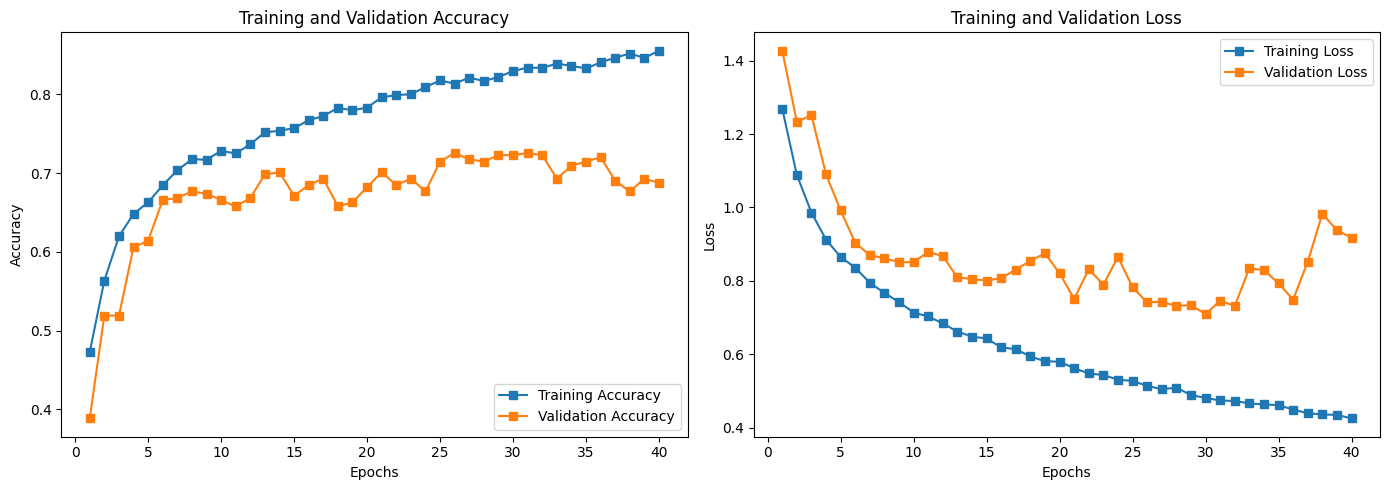

In [41]:
plot_training_history(history)

# TEST DIFFERENT EXISTING NETWORK ARCHITECTURE - AlexNet
As xception is too complex and crating network from scratch is not enough - it is time to try something less complex than xception but more advanced from trying from scratch

## test architecture from pytorch (layer sizes mismatch sizes from papers) 

In [47]:
from torchvision.models import alexnet

# Load a pretrained AlexNet model
model = alexnet(weights=True)

In [49]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [73]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, SeparableConv2D, GlobalAveragePooling2D, Dense, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.regularizers import l2


# Define input shape
input_shape = (224, 224, 3)  # Adjust according to your image dimensions

# Create the model
inputs = keras.Input(shape=input_shape)

# Features
x = Conv2D(64, kernel_size=(11, 11), strides=(4, 4), padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = Conv2D(192, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

# Classifier
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output = keras.layers.Dense(n_classes, activation="softmax",
                            # kernel_regularizer=l2(0.05),
                            # bias_regularizer=l2(0.05)
                            )(x)

model = keras.models.Model(inputs=inputs, outputs=output , name="alexnet_inspired")

In [74]:
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.02, momentum=0.9, decay=0.01) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

model.summary()

Model: "alexnet_inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_39 (Conv2D)          (None, 56, 56, 64)        23296     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 27, 27, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 27, 27, 192)       307392    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 13, 13, 192)      0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 13, 13, 384)  

c:\PythonScripts\image_classification\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [75]:
model_name = "network_from_AlexNet"
training_start = datetime.now()
epochs = 40
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/40
86/86 [==============================] - 8s 64ms/step - loss: 1.4525 - accuracy: 0.3528 - val_loss: 1.3122 - val_accuracy: 0.4457
Epoch 2/40
86/86 [==============================] - 5s 61ms/step - loss: 1.2618 - accuracy: 0.4626 - val_loss: 1.1754 - val_accuracy: 0.5217
Epoch 3/40
86/86 [==============================] - 5s 60ms/step - loss: 1.1235 - accuracy: 0.5349 - val_loss: 1.0521 - val_accuracy: 0.5625
Epoch 4/40
86/86 [==============================] - 5s 61ms/step - loss: 1.0450 - accuracy: 0.5854 - val_loss: 0.9934 - val_accuracy: 0.6250
Epoch 5/40
86/86 [==============================] - 5s 59ms/step - loss: 0.9728 - accuracy: 0.6243 - val_loss: 0.8941 - val_accuracy: 0.6739
Epoch 6/40
86/86 [==============================] - 5s 60ms/step - loss: 0.9110 - accuracy: 0.6453 - val_loss: 0.8727 - val_accuracy: 0.6603
Epoch 7/40
86/86 [==============================] - 5s 60ms/step - loss: 0.8458 - accuracy: 0.6759 - val_loss: 0.8317 - val_accuracy: 0.6984
Epoch 8/40
86

In [76]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

18/18 [==============================] - 1s 51ms/step - loss: 1.2738 - accuracy: 0.7436
Test loss: 1.2737736701965332
Test accuracy: 0.7436363697052002


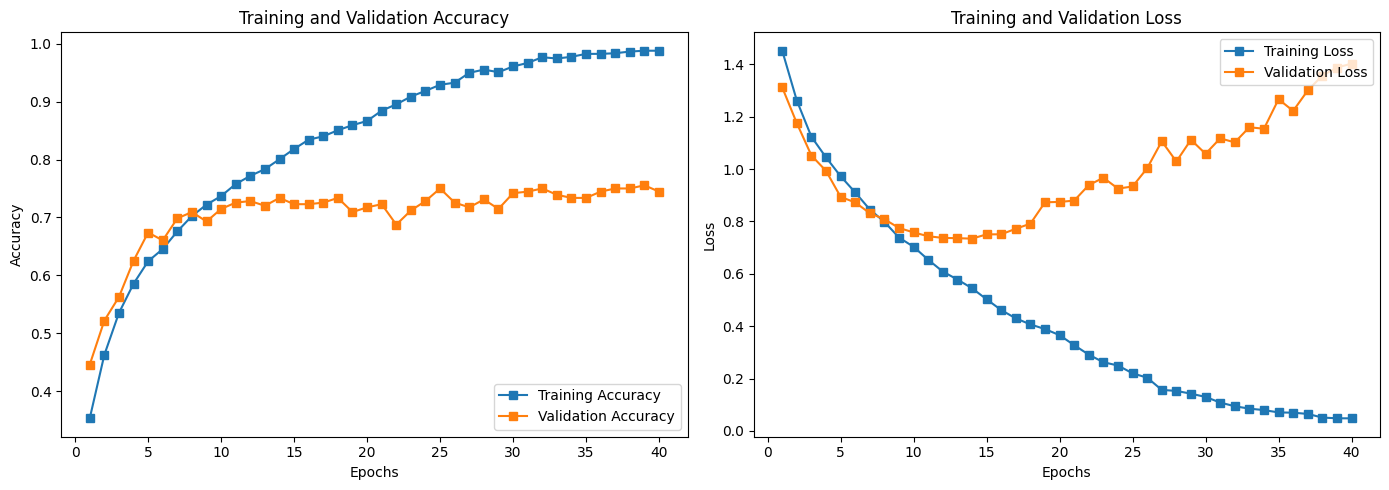

In [77]:
plot_training_history(history)

## Test architecture with correct layersizes and additional batchnormalization (generated by LLM after asking for it)

In [29]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, SeparableConv2D, GlobalAveragePooling2D, Dense, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (224, 224, 3)  # Adjust according to your image dimensions

# Create the model
inputs = keras.Input(shape=input_shape)

# Pierwsza grupa konwolucyjna
x = Conv2D(96, kernel_size=11, strides=4, padding="same")(inputs)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)

# Druga grupa konwolucyjna
x = Conv2D(256, kernel_size=5, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)

# Trzecia grupa konwolucyjna
x = Conv2D(384, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

# Czwarta grupa konwolucyjna
x = Conv2D(384, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

# Piąta grupa konwolucyjna
x = Conv2D(256, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(4096)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(4096)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

# I am assuming it may be already overkill so i am using l2 reguralization from the start
output = keras.layers.Dense(n_classes, activation="softmax",
                            kernel_regularizer=l2(0.05),
                            bias_regularizer=l2(0.05)
                            )(x)

model = keras.models.Model(inputs=inputs, outputs=output , name="alexnet_inspired")

# Compile the model
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.02, momentum=0.9, decay=0.01) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

model.summary()



Model: "alexnet_inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization_22 (Bat  (None, 56, 56, 96)       384       
 chNormalization)                                                
                                                                 
 activation_22 (Activation)  (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 27, 27, 256)  

c:\PythonScripts\image_classification\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [30]:
model_name = "network_from_AlexNet"
training_start = datetime.now()
epochs = 40
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/40
86/86 [==============================] - 8s 61ms/step - loss: 6.5817 - accuracy: 0.3321 - val_loss: 717.6705 - val_accuracy: 0.1440
Epoch 2/40
86/86 [==============================] - 5s 56ms/step - loss: 4.6638 - accuracy: 0.4437 - val_loss: 32.5237 - val_accuracy: 0.2473
Epoch 3/40
86/86 [==============================] - 5s 55ms/step - loss: 3.3302 - accuracy: 0.5011 - val_loss: 2.4421 - val_accuracy: 0.5054
Epoch 4/40
86/86 [==============================] - 5s 56ms/step - loss: 2.4340 - accuracy: 0.5487 - val_loss: 2.0109 - val_accuracy: 0.5136
Epoch 5/40
86/86 [==============================] - 5s 56ms/step - loss: 2.1062 - accuracy: 0.5705 - val_loss: 1.7630 - val_accuracy: 0.5299
Epoch 6/40
86/86 [==============================] - 5s 55ms/step - loss: 1.7423 - accuracy: 0.5887 - val_loss: 1.7091 - val_accuracy: 0.5380
Epoch 7/40
86/86 [==============================] - 5s 56ms/step - loss: 1.6558 - accuracy: 0.5945 - val_loss: 1.4270 - val_accuracy: 0.5924
Epoch 8/40

In [31]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

18/18 [==============================] - 1s 53ms/step - loss: 0.8426 - accuracy: 0.7218
Test loss: 0.8426110148429871
Test accuracy: 0.721818208694458


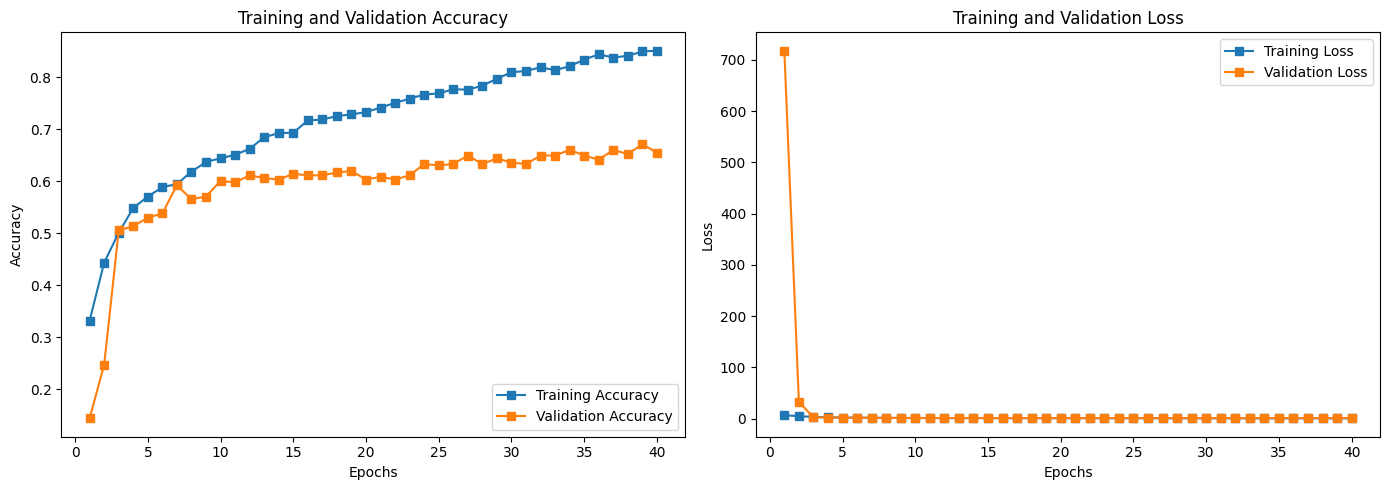

In [32]:
plot_training_history(history)

In [78]:
### Distance between train and test suggests overfiting, while low accuracy suggests that model is too simple to grasp patterns

In [35]:
model_name = "alexnet_base"
model.save(f'models/{model_name}.keras')

# EXPERIMENT WITH ALEXNET AS BASE TRYING TO IMPROVE GENERALIZATION

## add bunch of dense layers to see what happen

In [95]:
model = keras.models.load_model('models/alexnet_base.keras')

In [96]:
for layer in model.layers:
    layer.trainable = True

In [97]:
model.layers[-6]

In [98]:
# Fully connected layers
x = model.layers[-6].output

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Dense(54)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Dense(24)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Dense(12)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

# I am assuming it may be already overkill so i am using l2 reguralization from the start
output = keras.layers.Dense(n_classes, activation="softmax",
                            kernel_regularizer=l2(0.5),
                            bias_regularizer=l2(0.5)
                            )(x)

model = keras.models.Model(inputs=model.input, outputs=output , name="alexnet_inspired")

# Compile the model
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.01, momentum=0.9, decay=0.01) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

model.summary()



Model: "alexnet_inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization_22 (Bat  (None, 56, 56, 96)       384       
 chNormalization)                                                
                                                                 
 activation_22 (Activation)  (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 27, 27, 256)  

c:\PythonScripts\image_classification\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [99]:
model_name = "network_from_AlexNet_with_modified_dense"
training_start = datetime.now()
epochs = 40
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/40
86/86 [==============================] - 8s 66ms/step - loss: 1.9831 - accuracy: 0.2903 - val_loss: 1.5711 - val_accuracy: 0.3614
Epoch 2/40
86/86 [==============================] - 5s 61ms/step - loss: 1.5553 - accuracy: 0.3866 - val_loss: 1.4980 - val_accuracy: 0.4457
Epoch 3/40
86/86 [==============================] - 5s 61ms/step - loss: 1.5280 - accuracy: 0.4124 - val_loss: 1.4822 - val_accuracy: 0.4918
Epoch 4/40
86/86 [==============================] - 5s 61ms/step - loss: 1.5190 - accuracy: 0.4277 - val_loss: 1.4691 - val_accuracy: 0.5163
Epoch 5/40
86/86 [==============================] - 5s 61ms/step - loss: 1.5043 - accuracy: 0.4342 - val_loss: 1.4590 - val_accuracy: 0.5027
Epoch 6/40
86/86 [==============================] - 5s 61ms/step - loss: 1.4842 - accuracy: 0.4506 - val_loss: 1.4516 - val_accuracy: 0.5136
Epoch 7/40
86/86 [==============================] - 5s 61ms/step - loss: 1.4789 - accuracy: 0.4517 - val_loss: 1.4446 - val_accuracy: 0.5272
Epoch 8/40
86

In [100]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy) #82, 67, 72

18/18 [==============================] - 1s 49ms/step - loss: 1.3540 - accuracy: 0.5600
Test loss: 1.354033350944519
Test accuracy: 0.5600000023841858


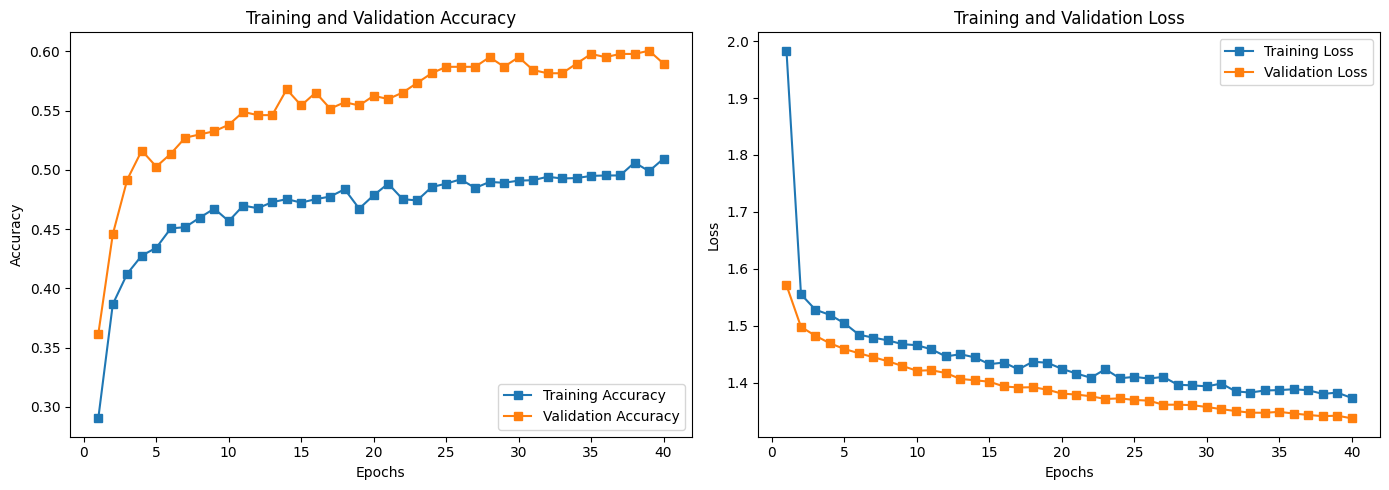

In [101]:
plot_training_history(history)

## Add more Conv2D layers instead of dense with freezing base 

In [102]:
model = keras.models.load_model('models/alexnet_base.keras')

In [103]:
for layer in model.layers:
    layer.trainable = False

In [104]:
# Fully connected layers
x = model.layers[-11].output

x = Conv2D(256, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(128, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(4096)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(4096)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

# I am assuming it may be already overkill so i am using l2 reguralization from the start
output = keras.layers.Dense(n_classes, activation="softmax",
                            kernel_regularizer=l2(0.5),
                            bias_regularizer=l2(0.5)
                            )(x)

model = keras.models.Model(inputs=model.input, outputs=output , name="alexnet_inspired")

# Compile the model
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.01, momentum=0.9, decay=0.01) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

model.summary()



Model: "alexnet_inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization_22 (Bat  (None, 56, 56, 96)       384       
 chNormalization)                                                
                                                                 
 activation_22 (Activation)  (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 27, 27, 256)  

In [105]:
model_name = "network_from_AlexNet_with_modified_dense"
training_start = datetime.now()
epochs = 40
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/40
86/86 [==============================] - 6s 61ms/step - loss: 2.6148 - accuracy: 0.6050 - val_loss: 2.0957 - val_accuracy: 0.5462
Epoch 2/40
86/86 [==============================] - 4s 45ms/step - loss: 1.3596 - accuracy: 0.6748 - val_loss: 1.3081 - val_accuracy: 0.6766
Epoch 3/40
86/86 [==============================] - 4s 44ms/step - loss: 0.9901 - accuracy: 0.7249 - val_loss: 1.1354 - val_accuracy: 0.6766
Epoch 4/40
86/86 [==============================] - 4s 42ms/step - loss: 0.8722 - accuracy: 0.7475 - val_loss: 1.0276 - val_accuracy: 0.6522
Epoch 5/40
86/86 [==============================] - 4s 42ms/step - loss: 0.8252 - accuracy: 0.7642 - val_loss: 0.9887 - val_accuracy: 0.6495
Epoch 6/40
86/86 [==============================] - 4s 42ms/step - loss: 0.7681 - accuracy: 0.7751 - val_loss: 0.9580 - val_accuracy: 0.6332
Epoch 7/40
86/86 [==============================] - 4s 42ms/step - loss: 0.7308 - accuracy: 0.7805 - val_loss: 0.9396 - val_accuracy: 0.6413
Epoch 8/40
86

In [106]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy) #82, 67, 72

18/18 [==============================] - 1s 50ms/step - loss: 0.7942 - accuracy: 0.7509
Test loss: 0.7942434549331665
Test accuracy: 0.7509090900421143


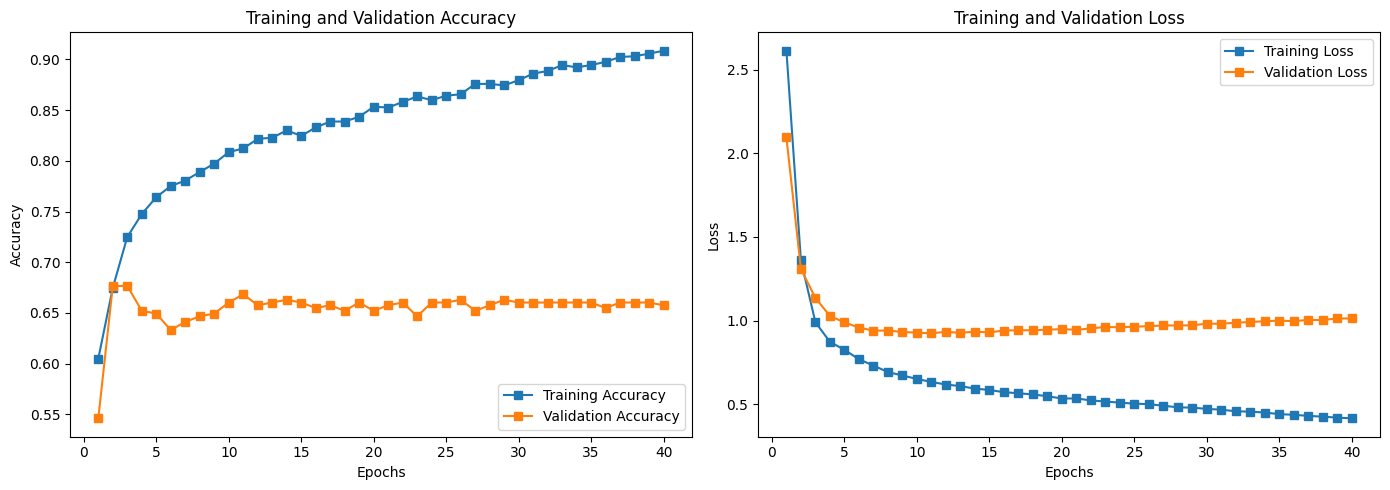

In [107]:
plot_training_history(history)

## Unfreeze and continue

In [108]:
for layer in model.layers:
    layer.trainable = True
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.01, momentum=0.9, decay=0.01) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

c:\PythonScripts\image_classification\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [109]:
model_name = "network_from_AlexNet_with_modified_dense"
training_start = datetime.now()
epochs = 40
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/40
86/86 [==============================] - 6s 55ms/step - loss: 1.9530 - accuracy: 0.5919 - val_loss: 3.4222 - val_accuracy: 0.5190
Epoch 2/40
86/86 [==============================] - 4s 51ms/step - loss: 1.4204 - accuracy: 0.6592 - val_loss: 1.2568 - val_accuracy: 0.6141
Epoch 3/40
86/86 [==============================] - 4s 50ms/step - loss: 0.9498 - accuracy: 0.7500 - val_loss: 0.9620 - val_accuracy: 0.7065
Epoch 4/40
86/86 [==============================] - 5s 52ms/step - loss: 0.7985 - accuracy: 0.7842 - val_loss: 0.9555 - val_accuracy: 0.6875
Epoch 5/40
86/86 [==============================] - 4s 51ms/step - loss: 0.6857 - accuracy: 0.8121 - val_loss: 0.9241 - val_accuracy: 0.6821
Epoch 6/40
86/86 [==============================] - 4s 51ms/step - loss: 0.5984 - accuracy: 0.8430 - val_loss: 0.9442 - val_accuracy: 0.6902
Epoch 7/40
86/86 [==============================] - 5s 52ms/step - loss: 0.5378 - accuracy: 0.8612 - val_loss: 0.9464 - val_accuracy: 0.6929
Epoch 8/40
86

In [110]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy) #82, 67, 72

18/18 [==============================] - 1s 36ms/step - loss: 0.8516 - accuracy: 0.7709
Test loss: 0.8515761494636536
Test accuracy: 0.7709090709686279


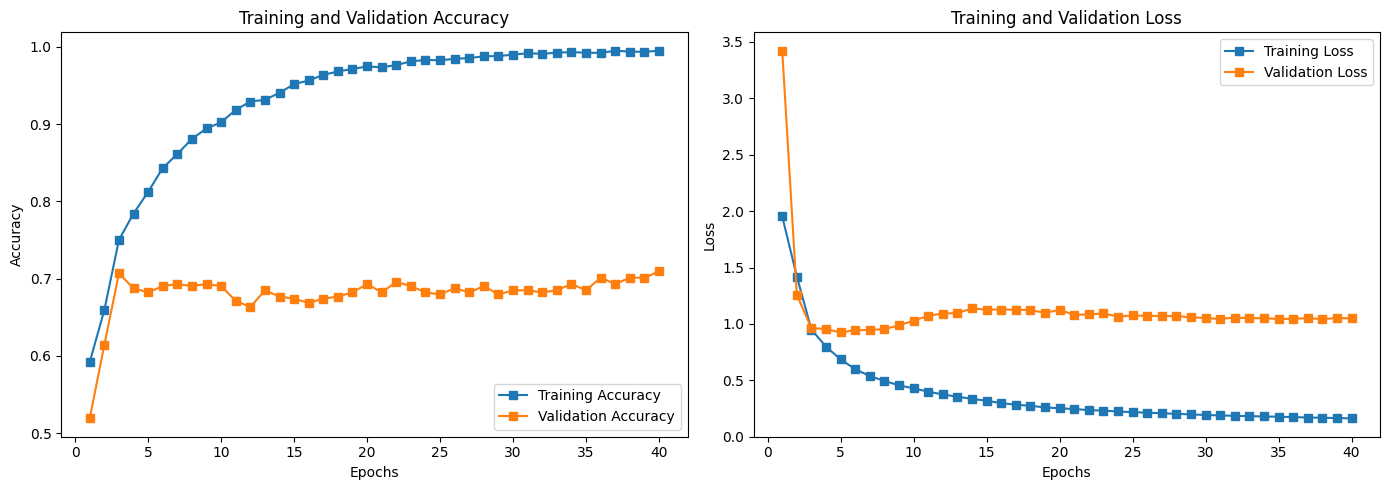

In [111]:
plot_training_history(history)

# FINAL XCEPTION TEST

## Try XCEPTION architecture without picking pre-trained weights to compare its accuracy

In [19]:


# Return to model variable
model = keras.models.load_model('models/xception_untrained.keras')

def reset_weights(model):
    for layer in model.layers:
        if isinstance(layer, (keras.layers.Dense, keras.layers.Conv2D)):
            layer.kernel_initializer = keras.initializers.GlorotUniform()
            layer.bias_initializer = keras.initializers.Zeros()
            
            if hasattr(layer, 'kernel') and layer.kernel is not None:
                new_kernel = layer.kernel_initializer(layer.kernel.shape)
                layer.kernel.assign(new_kernel)
            
            if hasattr(layer, 'bias') and layer.bias is not None:
                new_bias = layer.bias_initializer(layer.bias.shape)
                layer.bias.assign(new_bias)

# Użycie funkcji
reset_weights(model)



model_name = "xception_untrained_no_weights"


In [20]:
# Compile the model
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.01, momentum=0.9, decay=0.01) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])


In [21]:
training_start = datetime.now()
epochs = 40
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/40
86/86 [==============================] - 31s 323ms/step - loss: 1.1742 - accuracy: 0.5349 - val_loss: 2.3839 - val_accuracy: 0.2772
Epoch 2/40
86/86 [==============================] - 27s 316ms/step - loss: 0.7557 - accuracy: 0.7144 - val_loss: 2.3259 - val_accuracy: 0.2799
Epoch 3/40
86/86 [==============================] - 28s 323ms/step - loss: 0.4295 - accuracy: 0.8547 - val_loss: 1.7053 - val_accuracy: 0.4783
Epoch 4/40
86/86 [==============================] - 27s 319ms/step - loss: 0.2308 - accuracy: 0.9339 - val_loss: 0.8326 - val_accuracy: 0.7201
Epoch 5/40
86/86 [==============================] - 27s 319ms/step - loss: 0.1321 - accuracy: 0.9709 - val_loss: 0.5999 - val_accuracy: 0.7908
Epoch 6/40
86/86 [==============================] - 27s 319ms/step - loss: 0.0781 - accuracy: 0.9906 - val_loss: 0.5817 - val_accuracy: 0.8016
Epoch 7/40
86/86 [==============================] - 27s 313ms/step - loss: 0.0491 - accuracy: 0.9964 - val_loss: 0.5854 - val_accuracy: 0.8043

In [22]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy) #82, 67, 72

18/18 [==============================] - 1s 76ms/step - loss: 0.6145 - accuracy: 0.8182
Test loss: 0.6144567728042603
Test accuracy: 0.8181818127632141


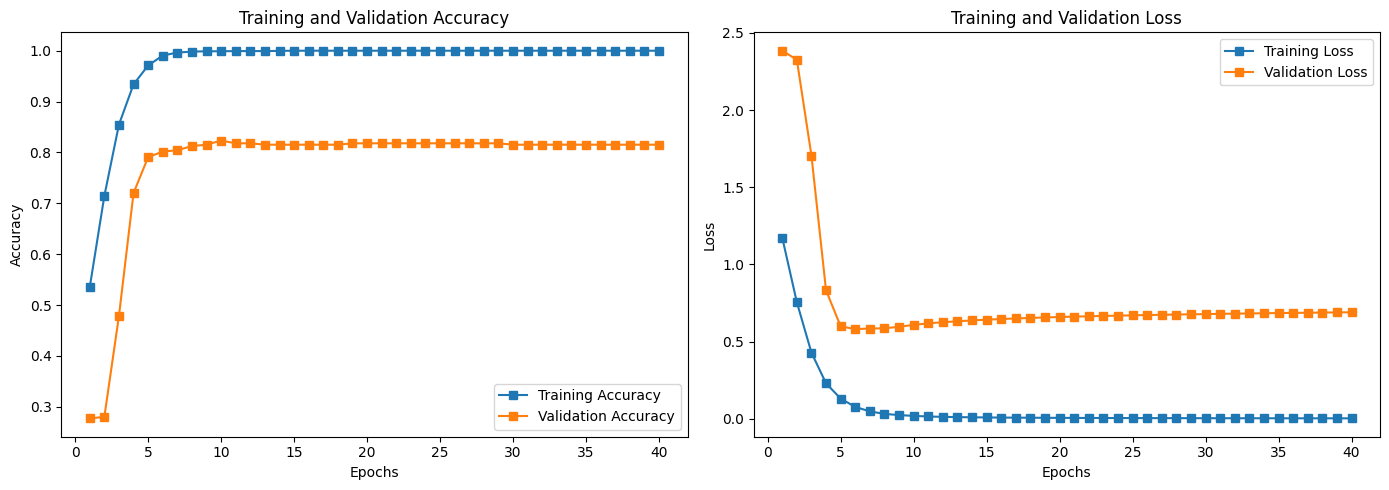

In [25]:
plot_training_history(history)

## Test if XCEPTION with data augumentation may break 95% accuracy
Previous test indicates that its hard to pass 85% without pre-training as we have not enough data
Previously we hit 93% limit on test/validation with pre-trained due to same reason
So, we want to test if it is possible to pass 95% mark with data augumentation

In [27]:
import tensorflow as tf
from tensorflow import keras
from functools import partial
train_split = 'train[:75%]'
cv_split = 'train[75%:85%]'
test_split = 'train[85%:]'

train_set_raw = tfds.load('tf_flowers', split=train_split, as_supervised=True)
valid_set_raw = tfds.load('tf_flowers', split=cv_split, as_supervised=True)
test_set_raw= tfds.load('tf_flowers', split=test_split, as_supervised=True)

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [28]:
# Return to model variable
model = keras.models.load_model('models/xception_untrained.keras')

# Compile the model
optimizer = tf.keras.optimizers.legacy.SGD(lr=0.01, momentum=0.9, decay=0.01) # Very low learning rate to prevent destroying model by dropout
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])


In [29]:
training_start = datetime.now()
epochs = 40
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs)
training_end = datetime.now()

Epoch 1/40
86/86 [==============================] - 32s 326ms/step - loss: 0.6245 - accuracy: 0.7736 - val_loss: 0.2656 - val_accuracy: 0.8940
Epoch 2/40
86/86 [==============================] - 28s 328ms/step - loss: 0.2231 - accuracy: 0.9266 - val_loss: 0.1575 - val_accuracy: 0.9457
Epoch 3/40
86/86 [==============================] - 27s 319ms/step - loss: 0.1422 - accuracy: 0.9524 - val_loss: 0.1434 - val_accuracy: 0.9538
Epoch 4/40
86/86 [==============================] - 28s 320ms/step - loss: 0.1226 - accuracy: 0.9589 - val_loss: 0.1255 - val_accuracy: 0.9538
Epoch 5/40
86/86 [==============================] - 28s 328ms/step - loss: 0.0816 - accuracy: 0.9782 - val_loss: 0.1277 - val_accuracy: 0.9565
Epoch 6/40
86/86 [==============================] - 28s 325ms/step - loss: 0.0814 - accuracy: 0.9749 - val_loss: 0.1314 - val_accuracy: 0.9565
Epoch 7/40
86/86 [==============================] - 28s 326ms/step - loss: 0.0697 - accuracy: 0.9833 - val_loss: 0.1251 - val_accuracy: 0.9592

In [30]:
loss, accuracy = model.evaluate(test_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy) #82, 67, 72

18/18 [==============================] - 2s 77ms/step - loss: 0.1119 - accuracy: 0.9636
Test loss: 0.11187201738357544
Test accuracy: 0.9636363387107849


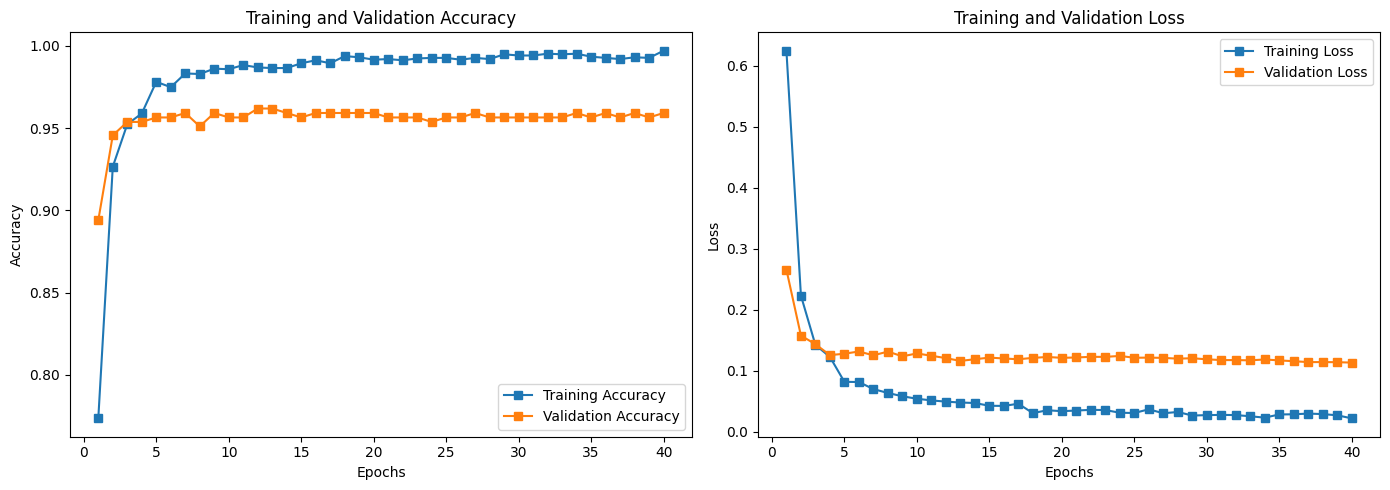

In [31]:
plot_training_history(history)